In [1]:
#import necessary python packages
import scanpy as sc 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy
import pooch
import omicverse as ov
import anndata
import re


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.5.4, Tutorials: https://omicverse.readthedocs.io/


In [2]:
# 文件所在的目录路径
filePath = r"/Users/jialechen/Desktop/Analysis_work/Morrbid/scRNAseq2"
# 生成文件的完整路径列表
file_paths = ['{}/GSM5813881_sham_filtered_feature_bc_matrix.h5'.format(filePath),
             '{}/GSM5813883_formed_filtered_feature_bc_matrix.h5'.format(filePath),
             '{}/GSM5813885_ruptured_filtered_feature_bc_matrix.h5'.format(filePath)]
adatas = []


for file_path in file_paths:
    # 读取 h5 文件
    sample_adata = sc.read_10x_h5(file_path)
    # 确保变量名的唯一性
    sample_adata.var_names_make_unique()
    # 假设你知道每个文件对应的样本名称，这里可以添加更多元数据
    sample_name = file_path.split('/')[-1].split('_filtered_feature_bc_matrix.h5')[0]
    # 在 obs 中添加 sample_name 作为新列
    sample_adata.obs['sample_name'] = sample_name
    adatas.append(sample_adata)


# 拼接数据
adata = anndata.concat(adatas, label="sample")
# 确保观测名的唯一性
adata.obs_names_make_unique()


# 修改 sample 列，去掉 GSM 号
adata.obs['sample'] = adata.obs['sample_name'].apply(lambda x: re.sub(r'GSM[0-9]+_', '', x))


# 删除 sample_name 列
adata.obs.drop(columns=['sample_name'], inplace=True)


print(adata.obs["sample"].value_counts())
print(adata)
adata.obs['sample'].unique()

sample
ruptured    9001
formed      8958
sham        7560
Name: count, dtype: int64
AnnData object with n_obs × n_vars = 25519 × 32285
    obs: 'sample'


array(['sham', 'formed', 'ruptured'], dtype=object)

In [3]:
adata.obs

sample
AAACCCACAACCCTCT-1      sham
AAACCCACACGGATCC-1      sham
AAACCCACAGTTACCA-1      sham
AAACCCAGTACCCGAC-1      sham
AAACCCAGTGACATCT-1      sham
...                      ...
TTTGTTGGTCCCAAAT-1  ruptured
TTTGTTGGTTCTCCAC-1  ruptured
TTTGTTGTCGATCCCT-1  ruptured
TTTGTTGTCGGAGTAG-1  ruptured
TTTGTTGTCGGCTGAC-1  ruptured

[25519 rows x 1 columns]

In [4]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

In [5]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


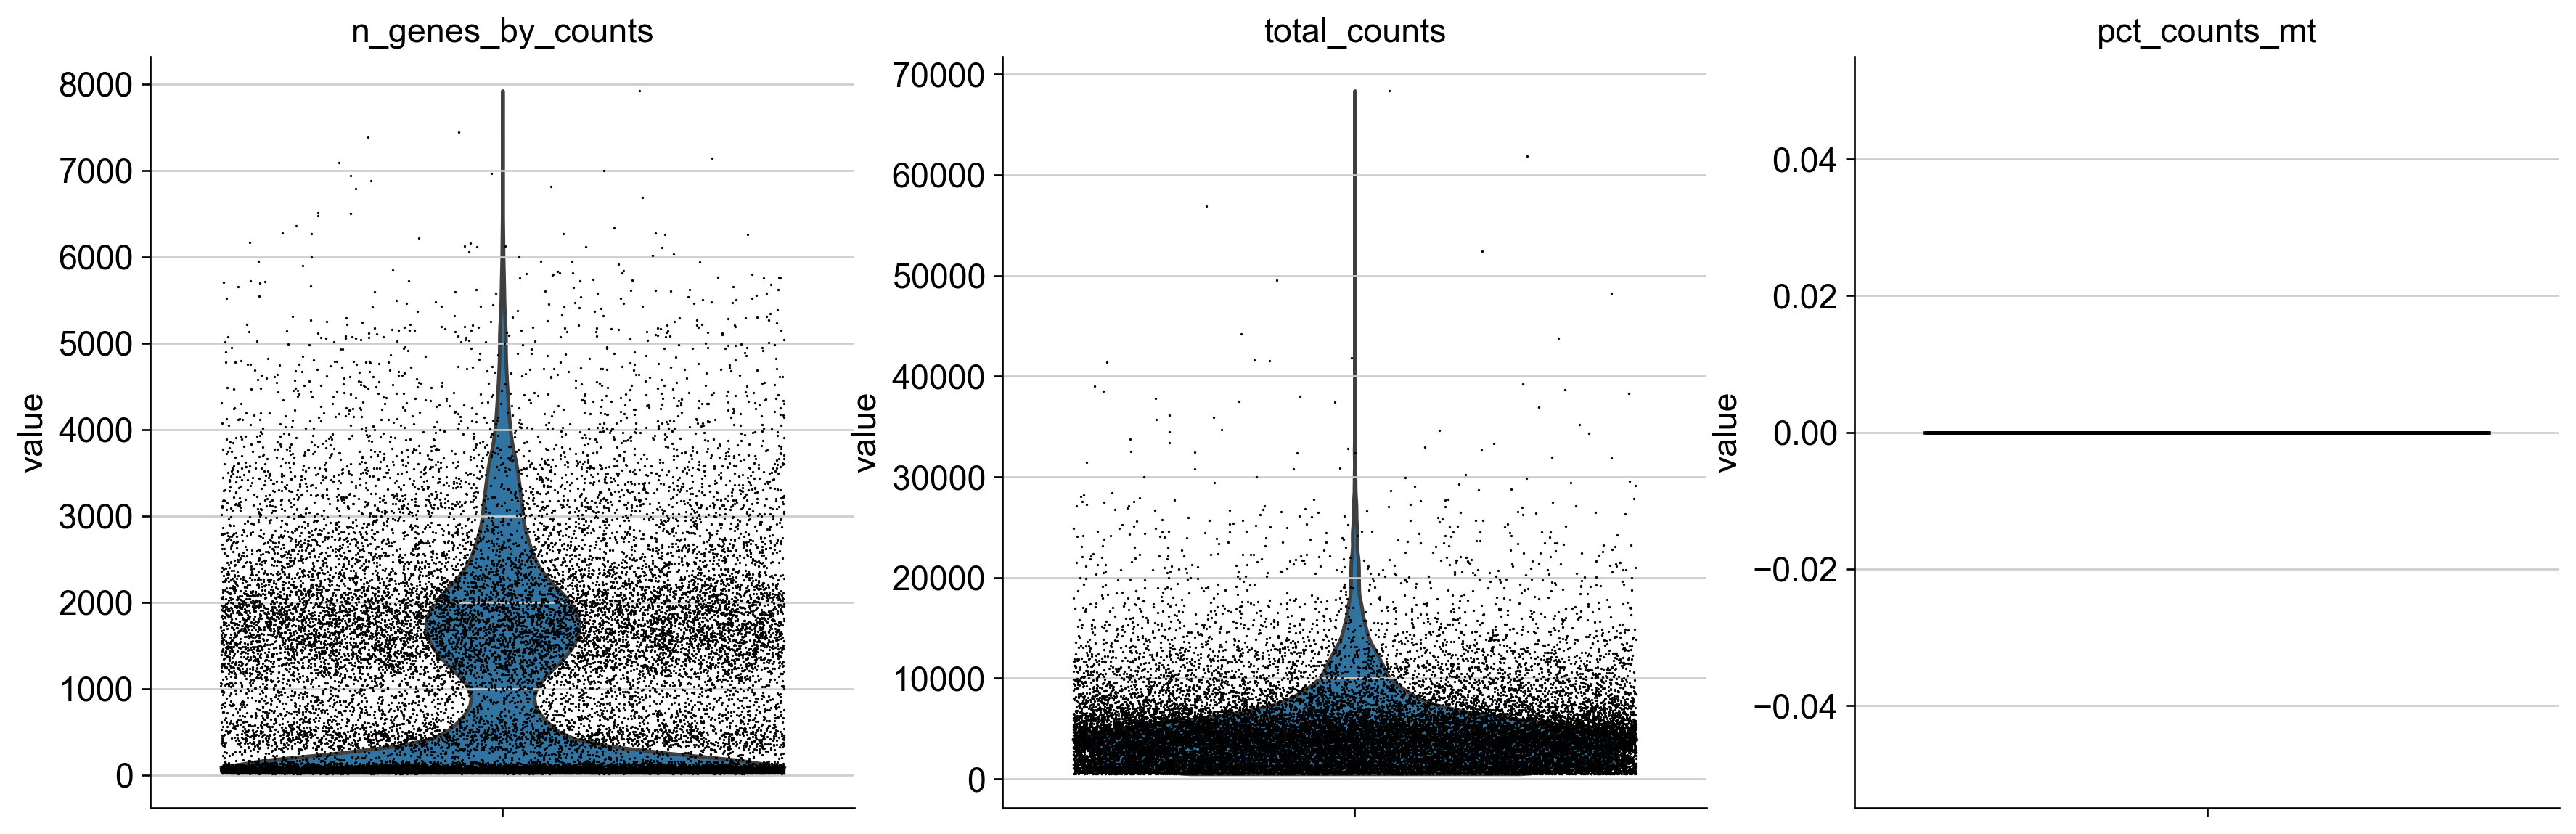

In [6]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

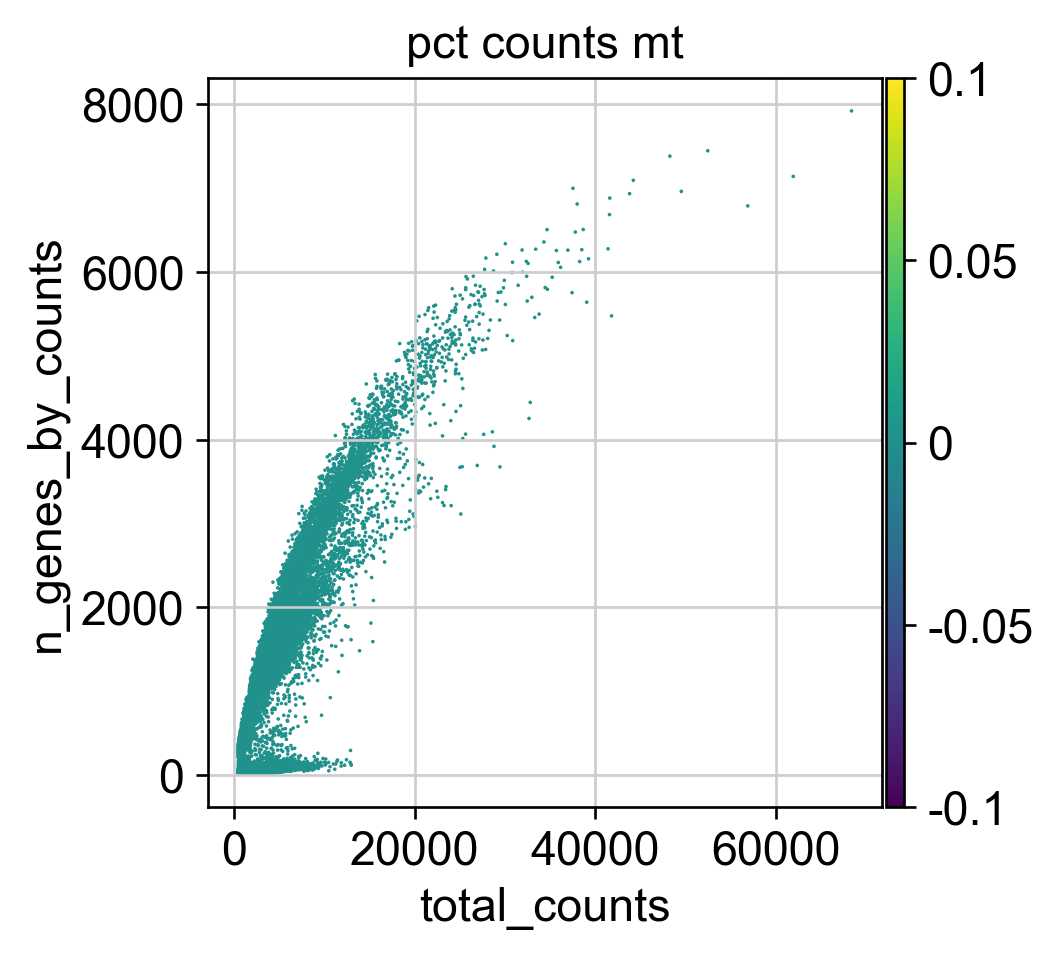

In [7]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [8]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

In [9]:
# Saving count data
adata.layers["counts"] = adata.X.copy()

In [10]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

In [11]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="sample")

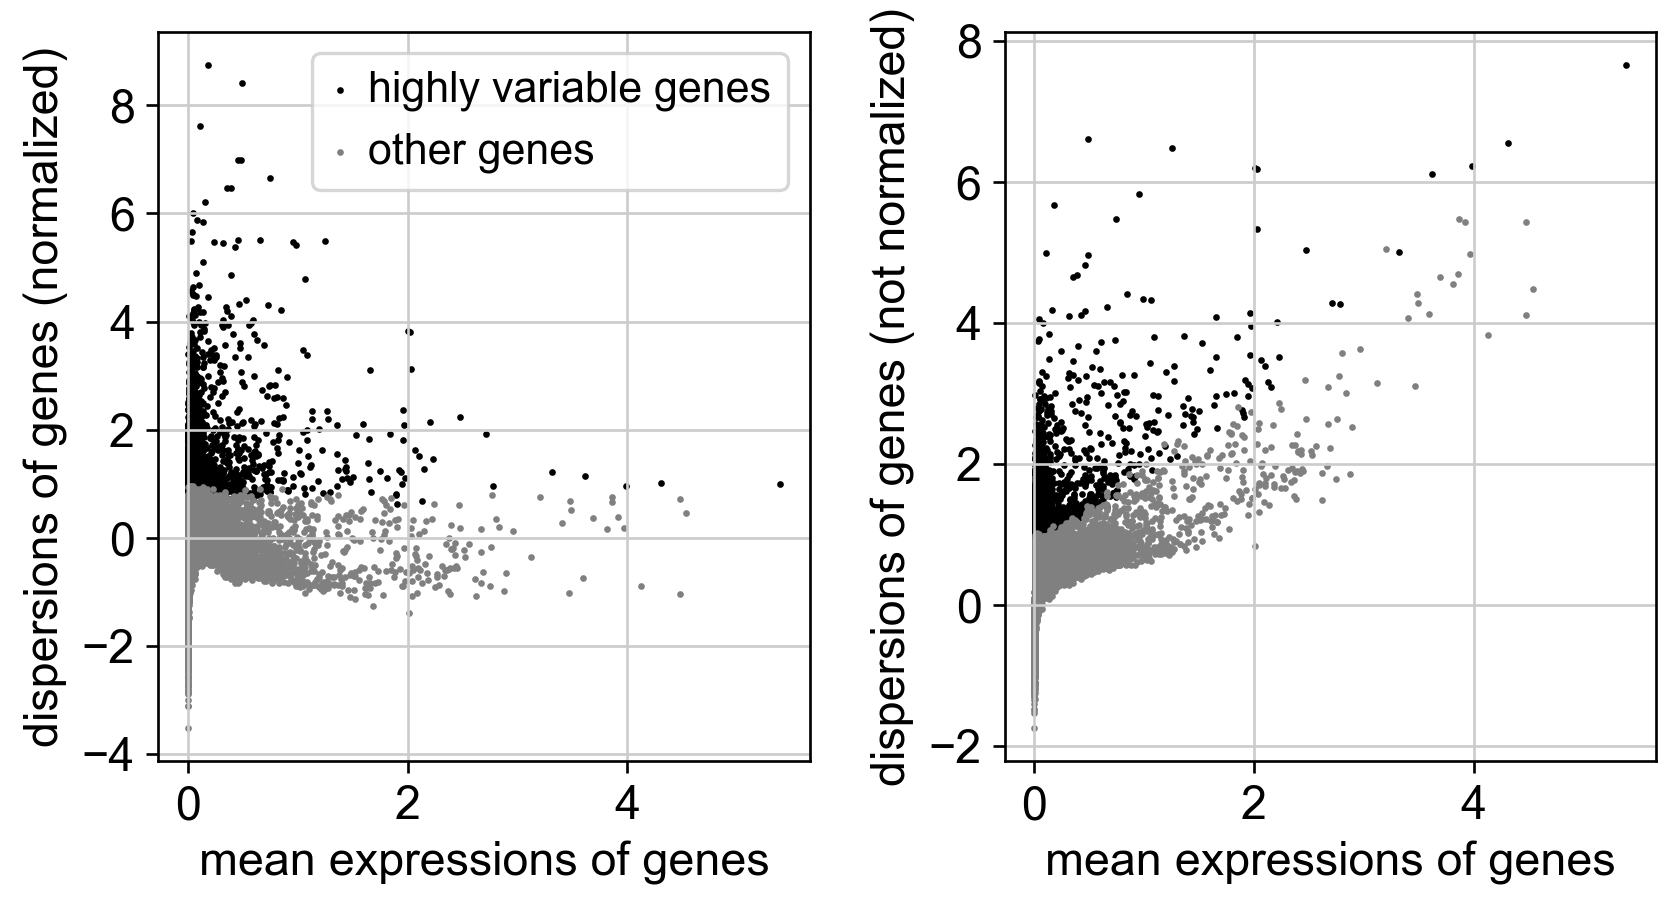

In [12]:
sc.pl.highly_variable_genes(adata)

In [13]:
sc.tl.pca(adata)

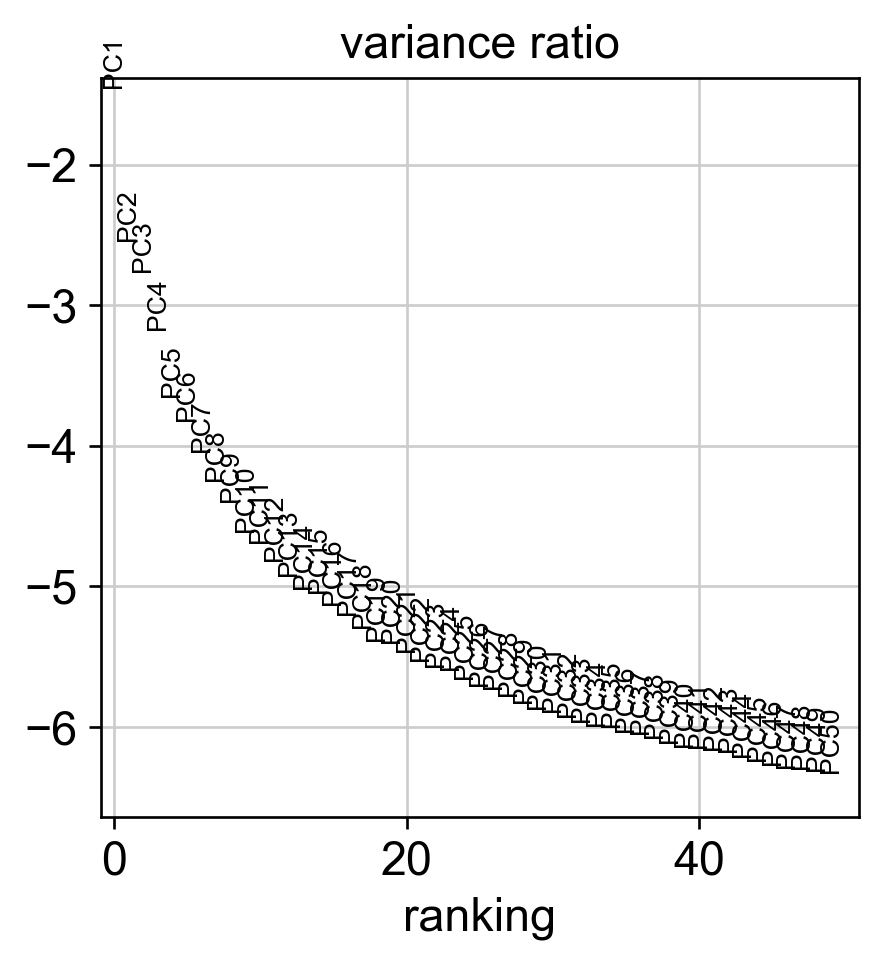

In [14]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

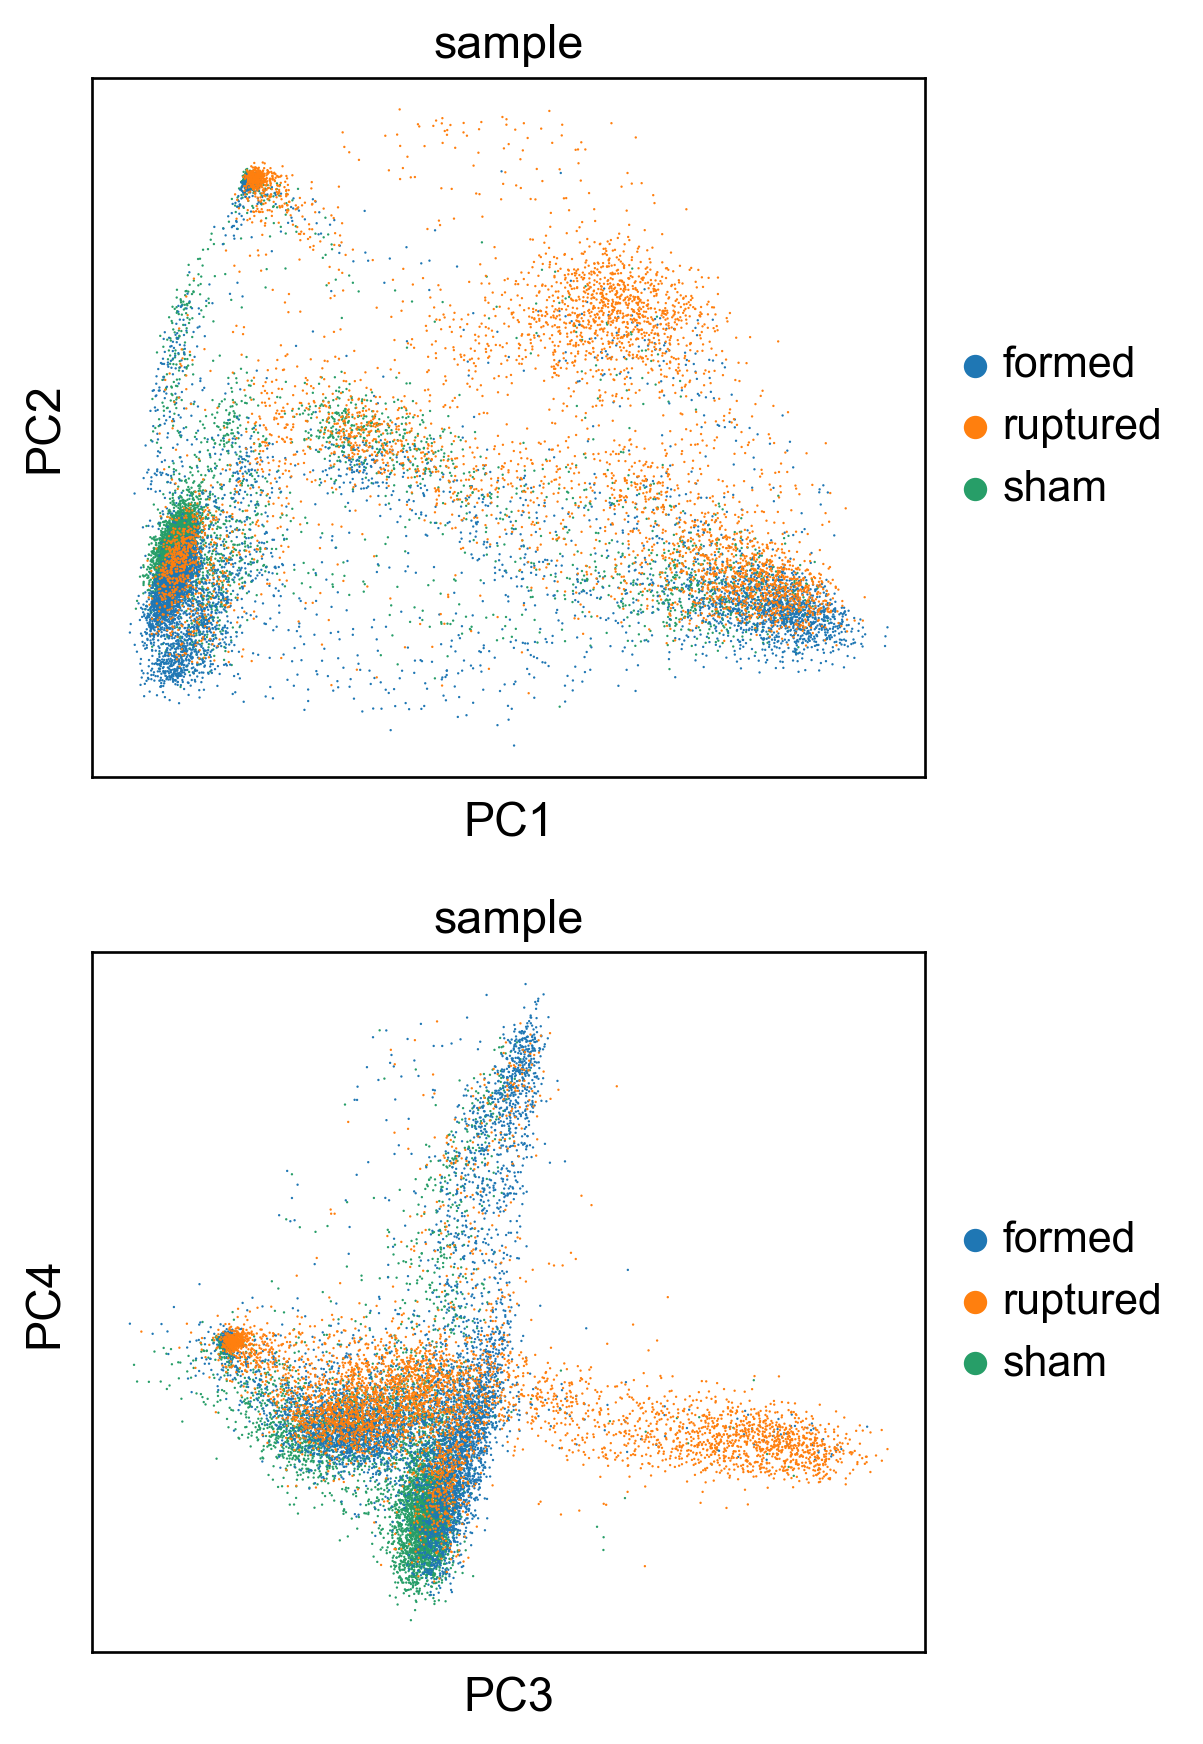

In [15]:
sc.pl.pca(
    adata,
    color=["sample"],
    dimensions=[(0, 1), (2, 3)],
    ncols=1,
    size=2,
)

In [16]:
sc.pp.neighbors(adata)

In [17]:
sc.tl.umap(adata)

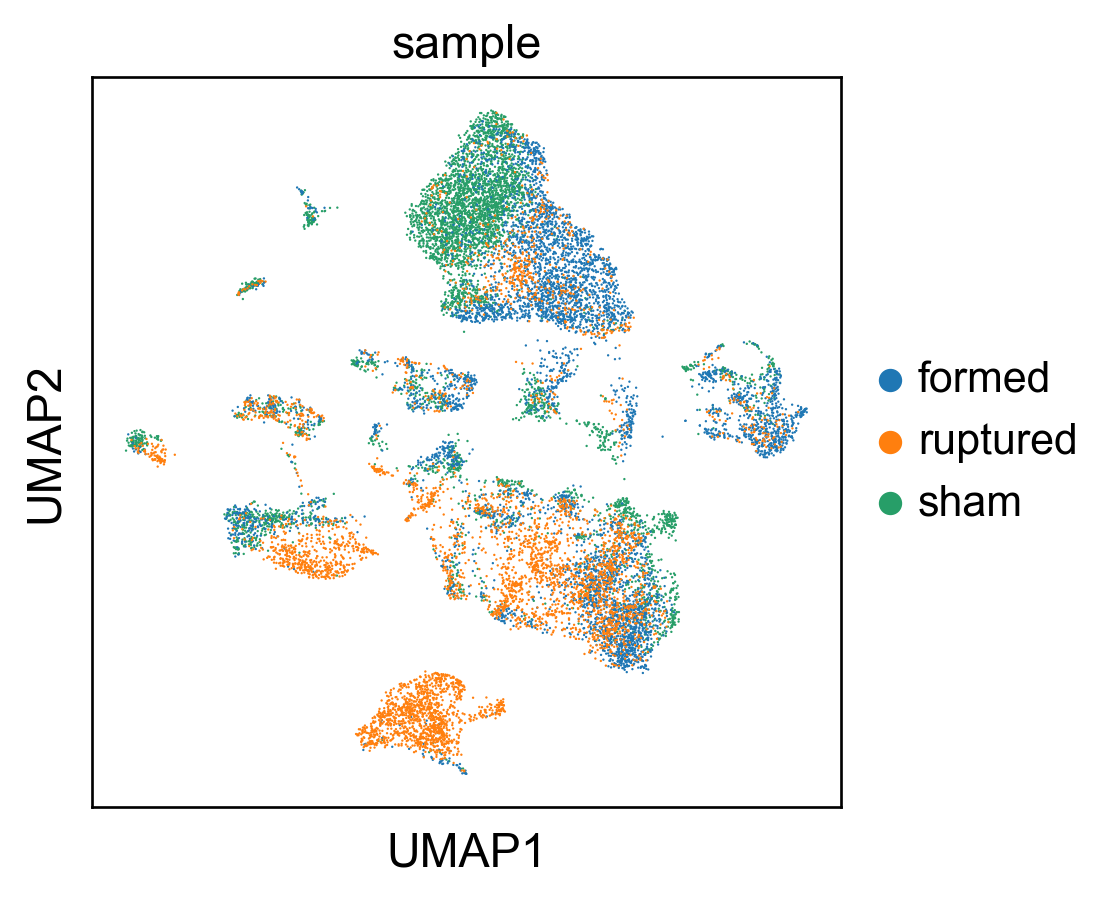

In [18]:
sc.pl.umap(
    adata,
    color="sample",
    # Setting a smaller point size to get prevent overlap
    size=2,
)

In [19]:
# Using the igraph implementation and a fixed number of iterations can be significantly faster, especially for larger datasets
sc.tl.leiden(adata, n_iterations=2)

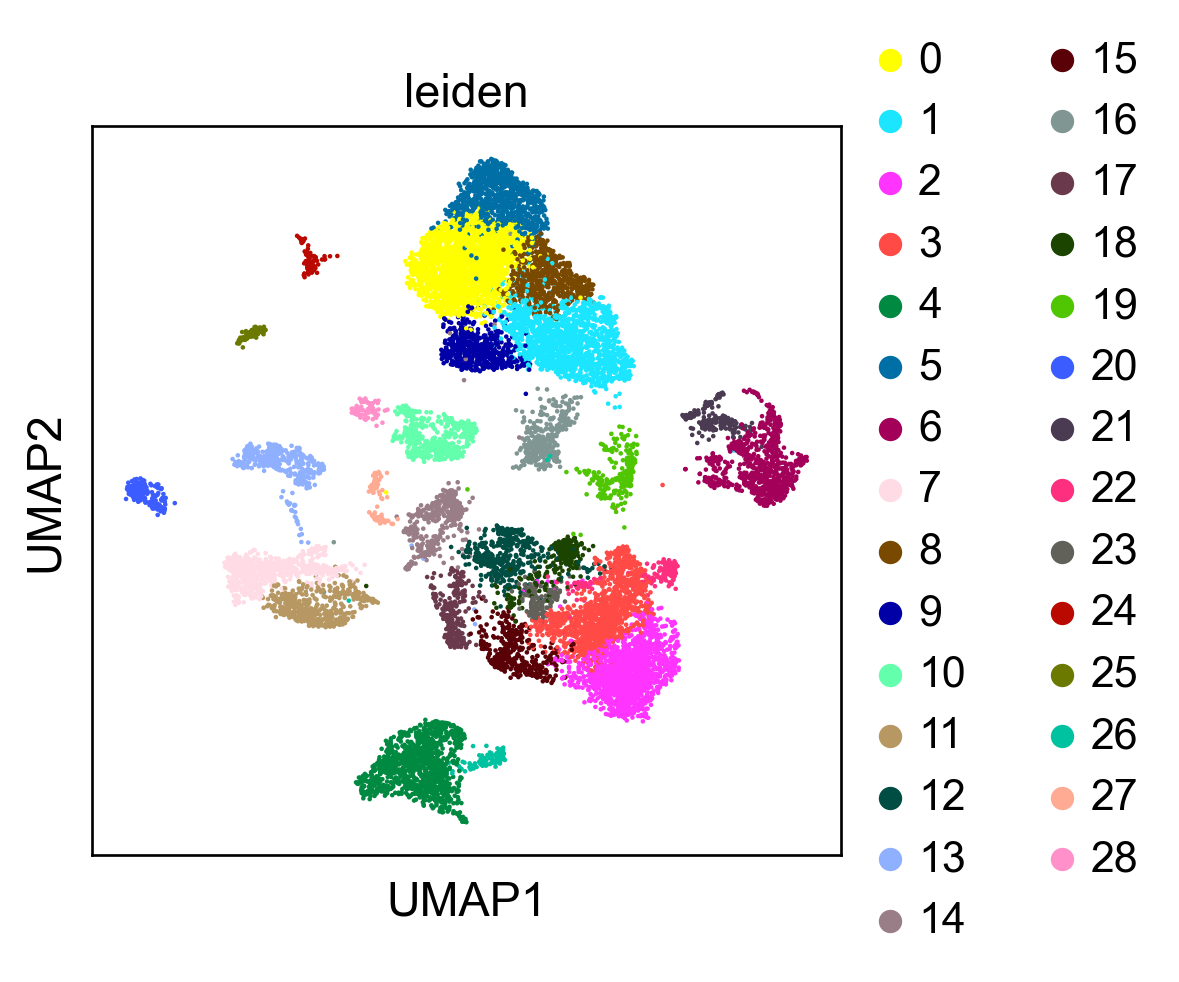

In [20]:
sc.pl.umap(adata, color=["leiden"])

In [21]:
for res in [0.02, 0.1, 0.5]:
    sc.tl.leiden(
        adata, key_added=f"leiden_res_{res:4.2f}", resolution=res
    )

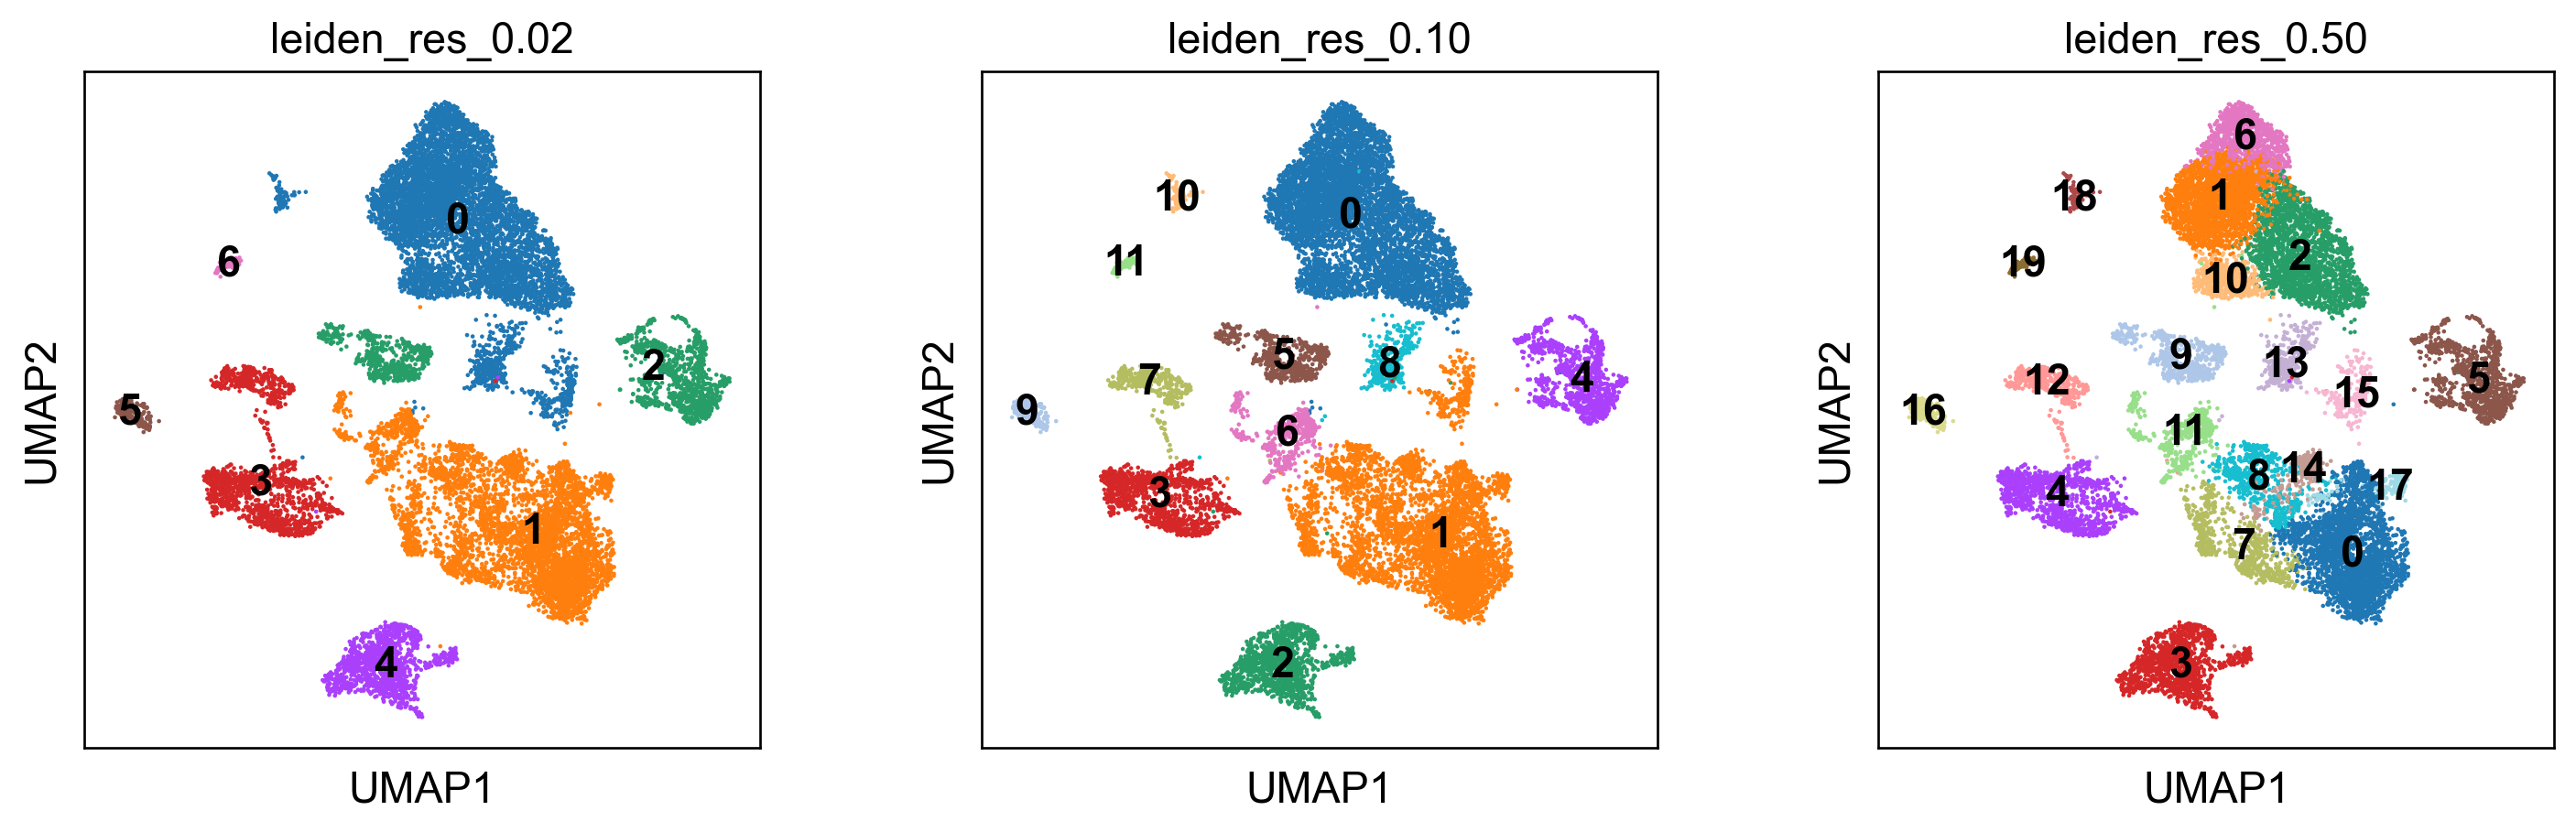

In [22]:
sc.pl.umap(
    adata,
    color=["leiden_res_0.02", "leiden_res_0.10", "leiden_res_0.50"],
    legend_loc="on data",
)

In [23]:
marker_genes = {
    "VSMC":["Myh11", "Tagln", "Acta2"],
    "Mo/MФ":["Cd68", "C1qa", "C1qb"],
    "Neutrophil":["S100a9", "S100a8", "Lcn2"],  
    "Fibroblast":["Dcn", "Col1a1", "Lum"],  
    "Endothelium":["Cdh5", "Pecam1", "Esam"],  
    "T lymphocyte":["Cd3d","Cd3g","Cd28"],  
    "Pericyte":["Rgs5", "Rgs16", "Kcnj8"],  
    "B lymphocyte":["Cd79a","Cd79b","Ly6d"],  
    "Dendritic cells":["Cd209a", "Ccr7", "Ifitm1"],  
    "Mast cells":["Mcpt4", "Cma1", "Tpsb2"],  
    }

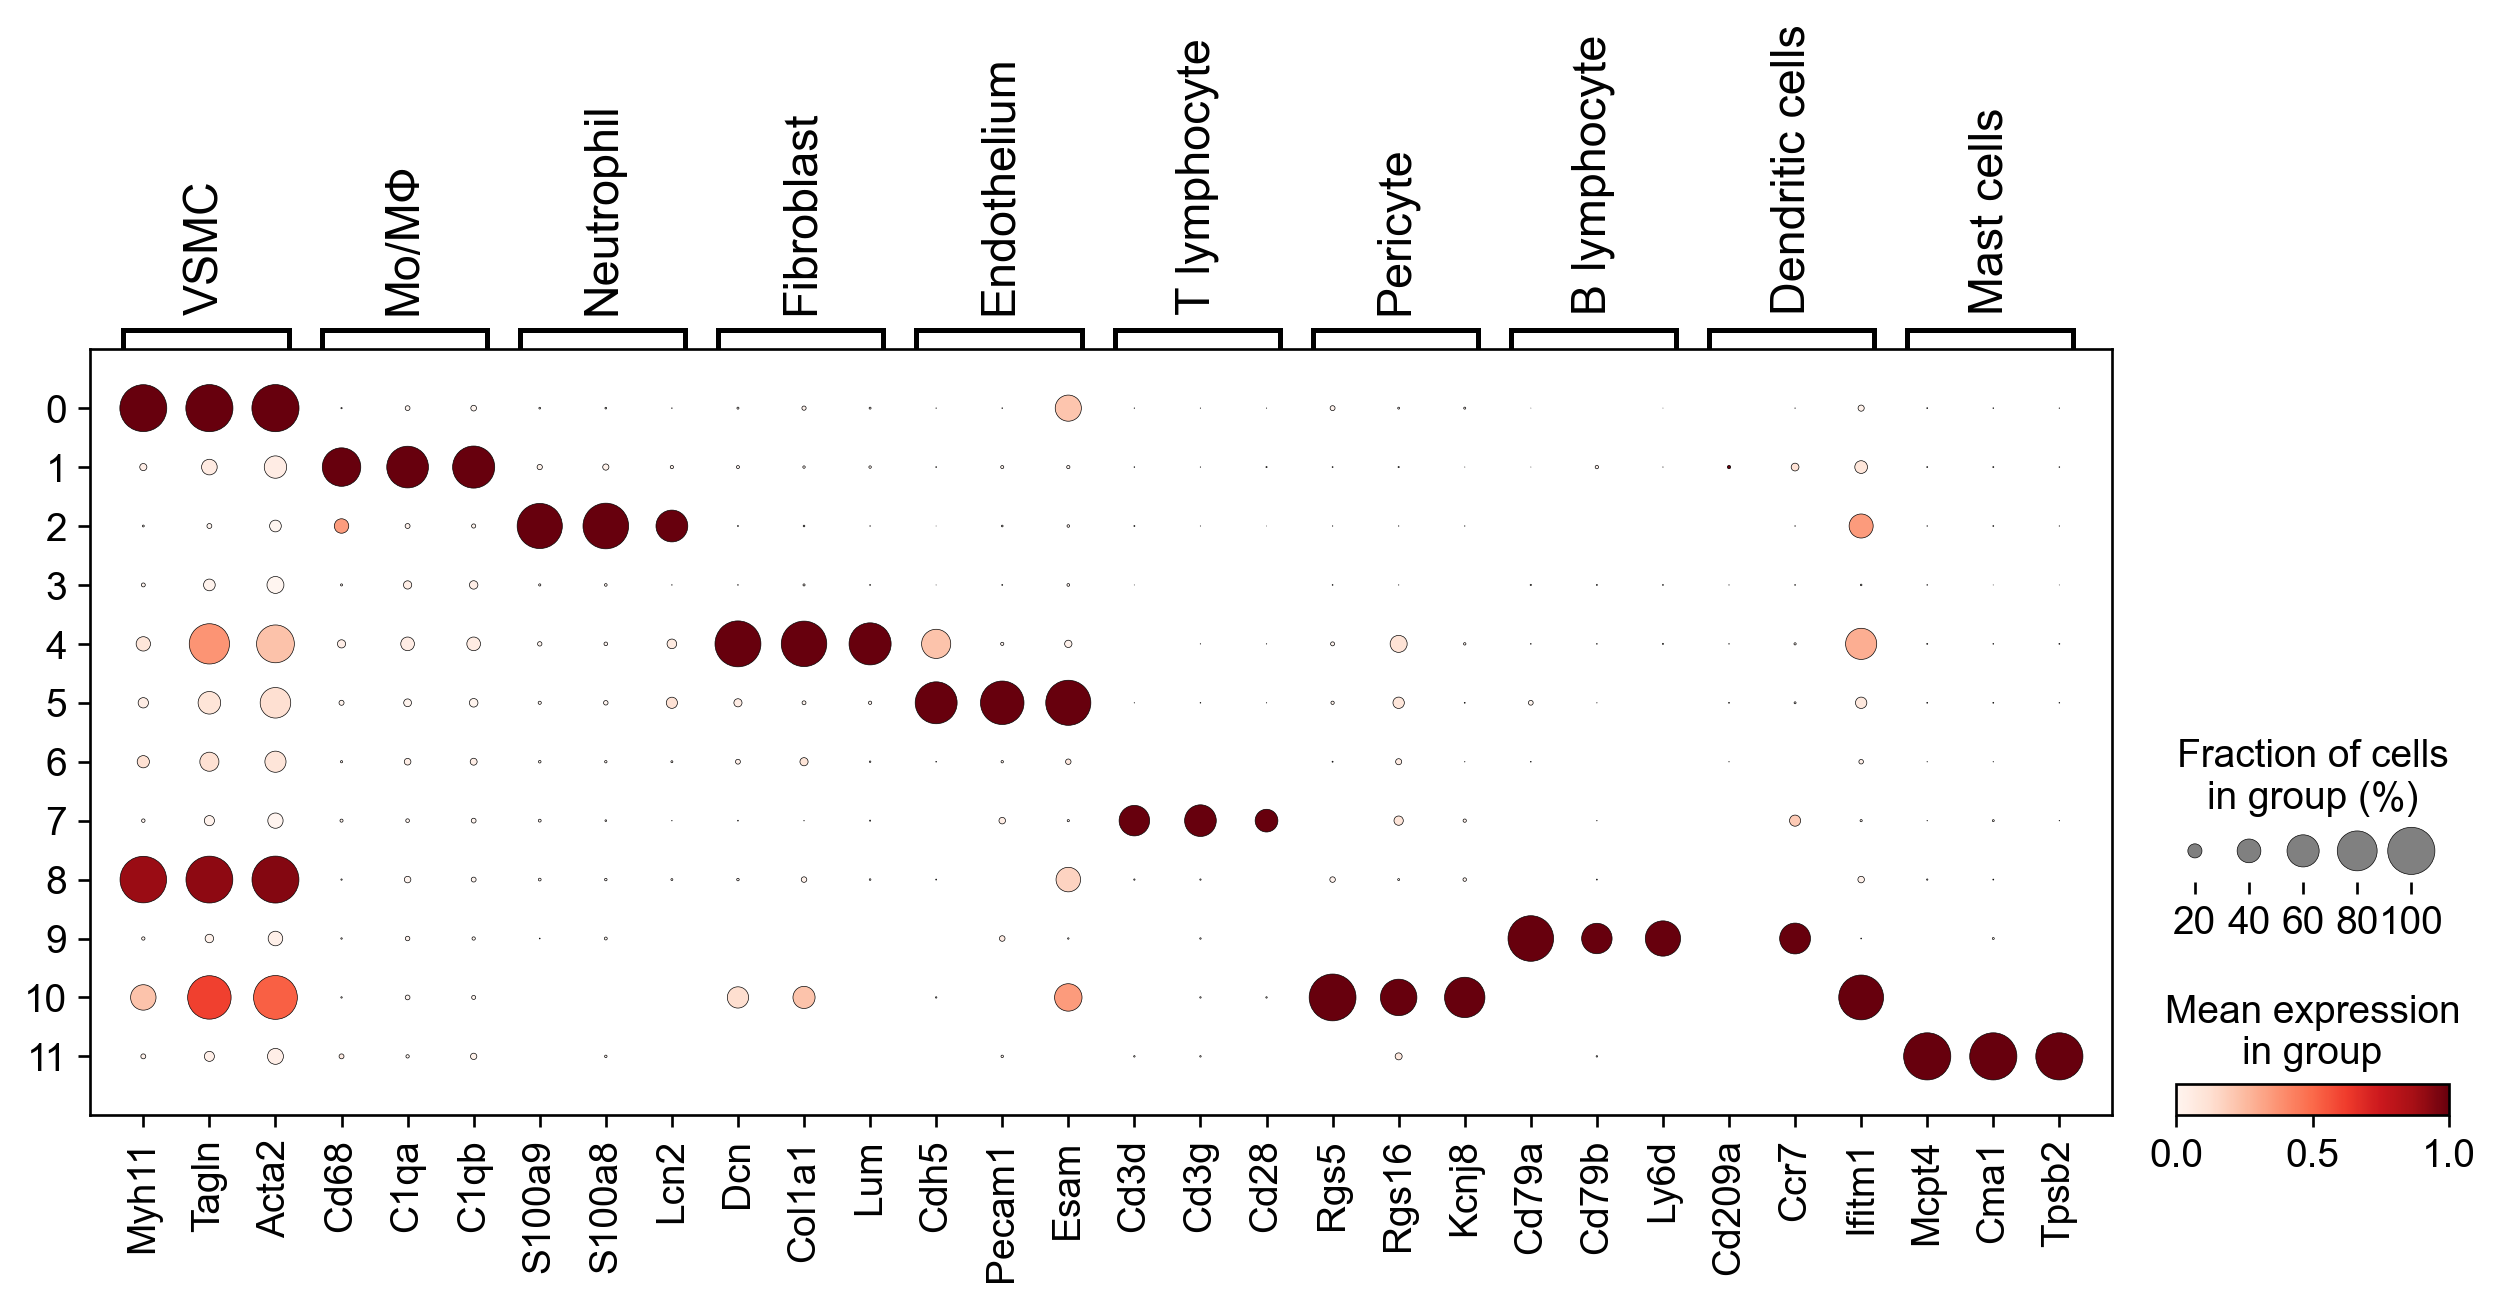

In [24]:
sc.pl.dotplot(adata, marker_genes, groupby="leiden_res_0.10", standard_scale="var")

In [25]:
adata.obs["cell_type"] = adata.obs["leiden_res_0.10"].map(
    {
        "0": "VSMC",
        "1": "Mo/MФ",
        "2": "Neutrophil",
        "3": "VSMC",
        "4": "Fibroblast",
        "5": "Endothelium",
        "6": "VSMC",
        "7": "T lymphocyte",
        "8": "VSMC",
        "9": "B lymphocyte",
        "10": "Pericyte",
        "11": "Mast cells",
    }
)

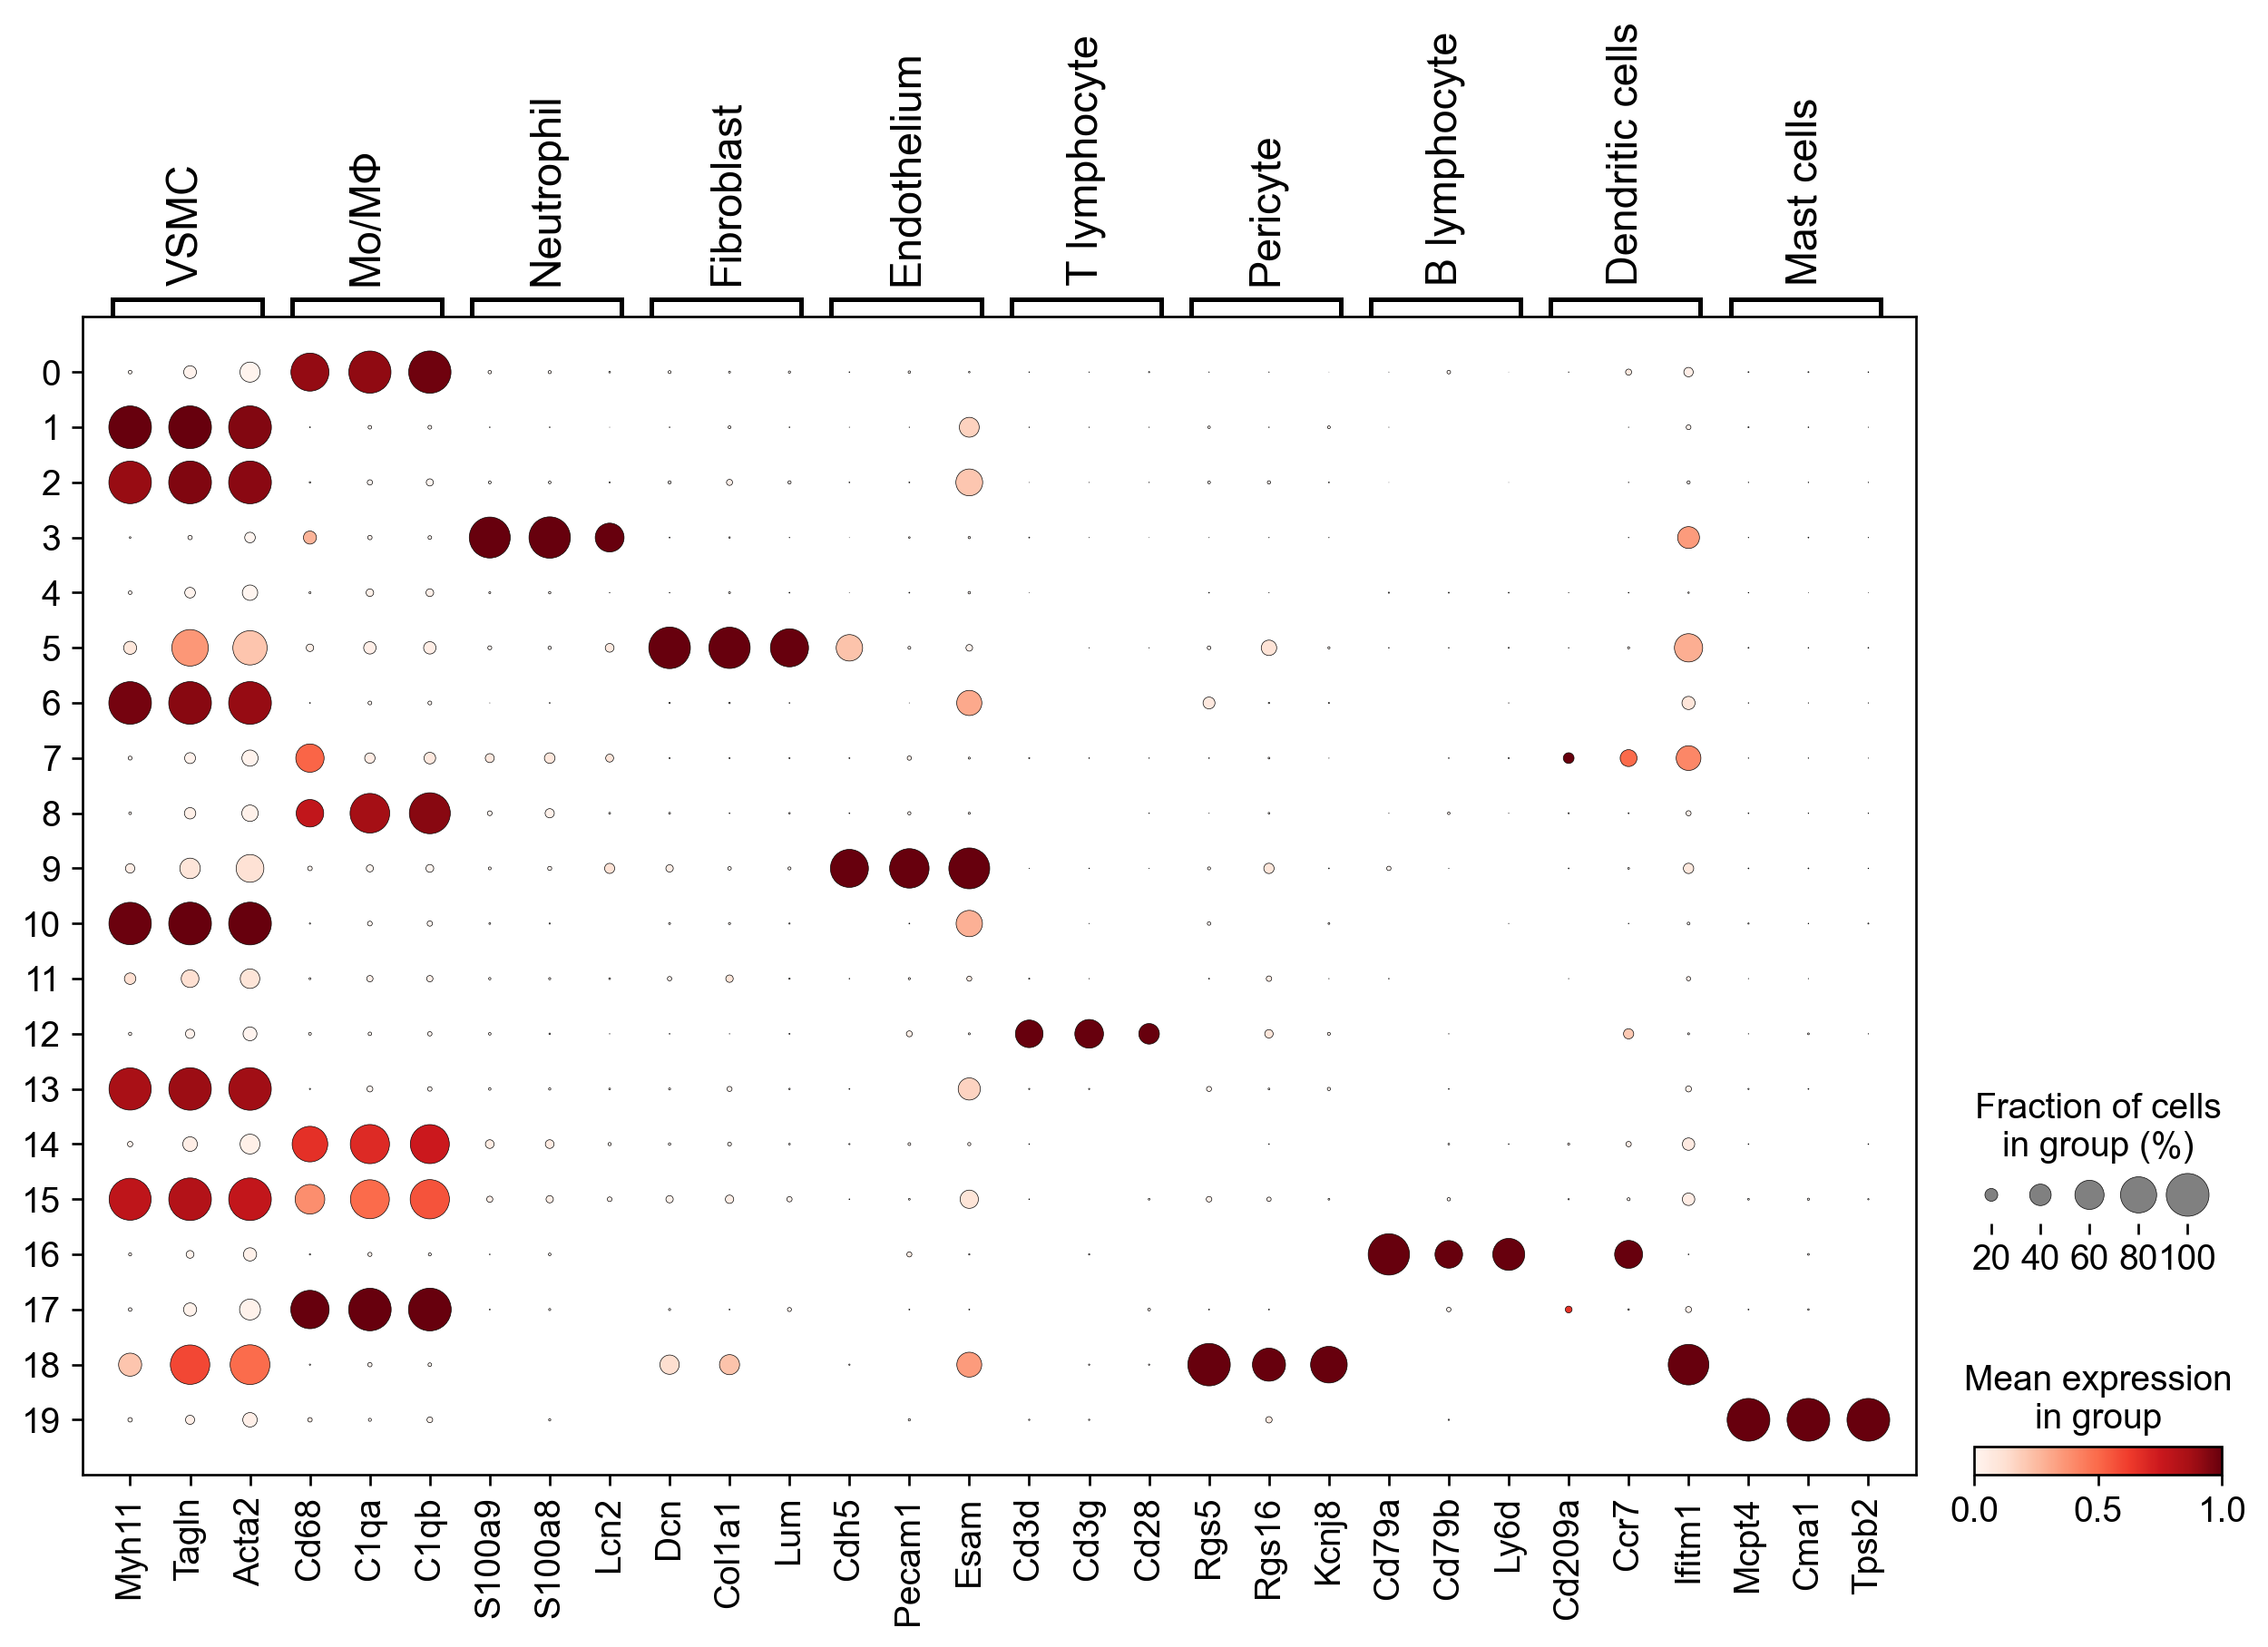

In [26]:
sc.pl.dotplot(adata, marker_genes, groupby="leiden_res_0.50", standard_scale="var")

In [27]:
# Obtain cluster-specific differentially expressed genes
sc.tl.rank_genes_groups(adata, groupby="leiden_res_0.10", method="wilcoxon")

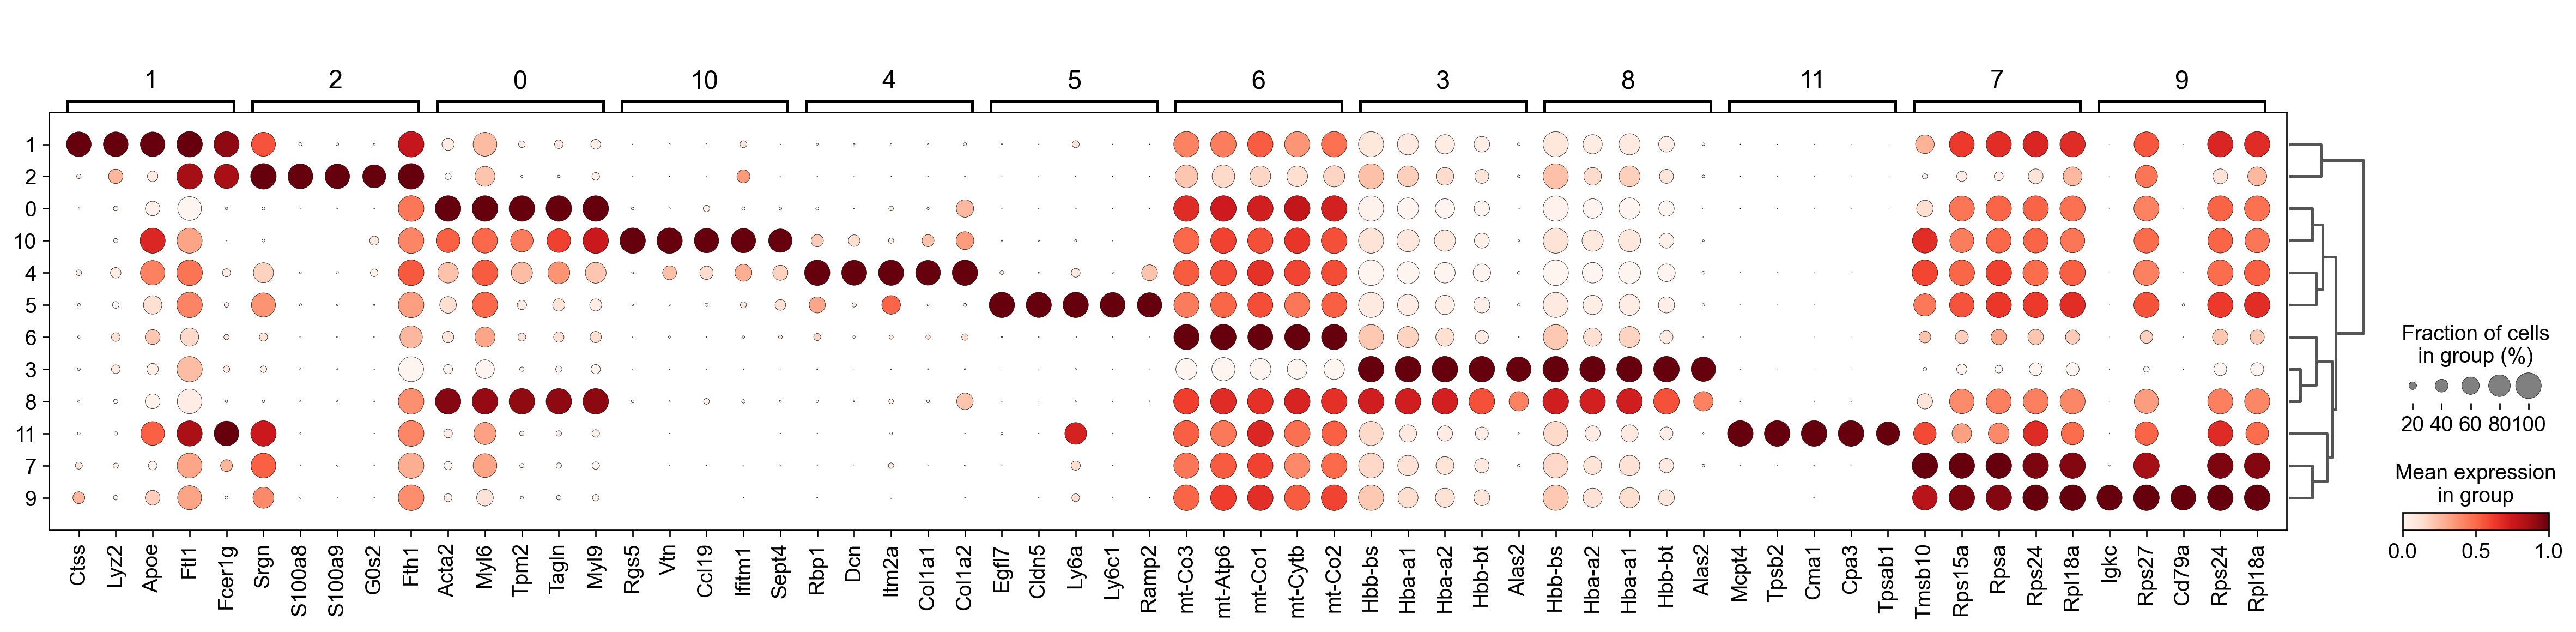

In [28]:
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="leiden_res_0.10", standard_scale="var", n_genes=5
)

In [29]:
sc.get.rank_genes_groups_df(adata, group="1").head(5)

names     scores  logfoldchanges  pvals  pvals_adj
0    Ctss  93.089882        6.973437    0.0        0.0
1    Lyz2  90.997566        6.734046    0.0        0.0
2    Apoe  86.806061        6.282999    0.0        0.0
3    Ftl1  86.657059        3.479948    0.0        0.0
4  Fcer1g  84.125221        4.727290    0.0        0.0

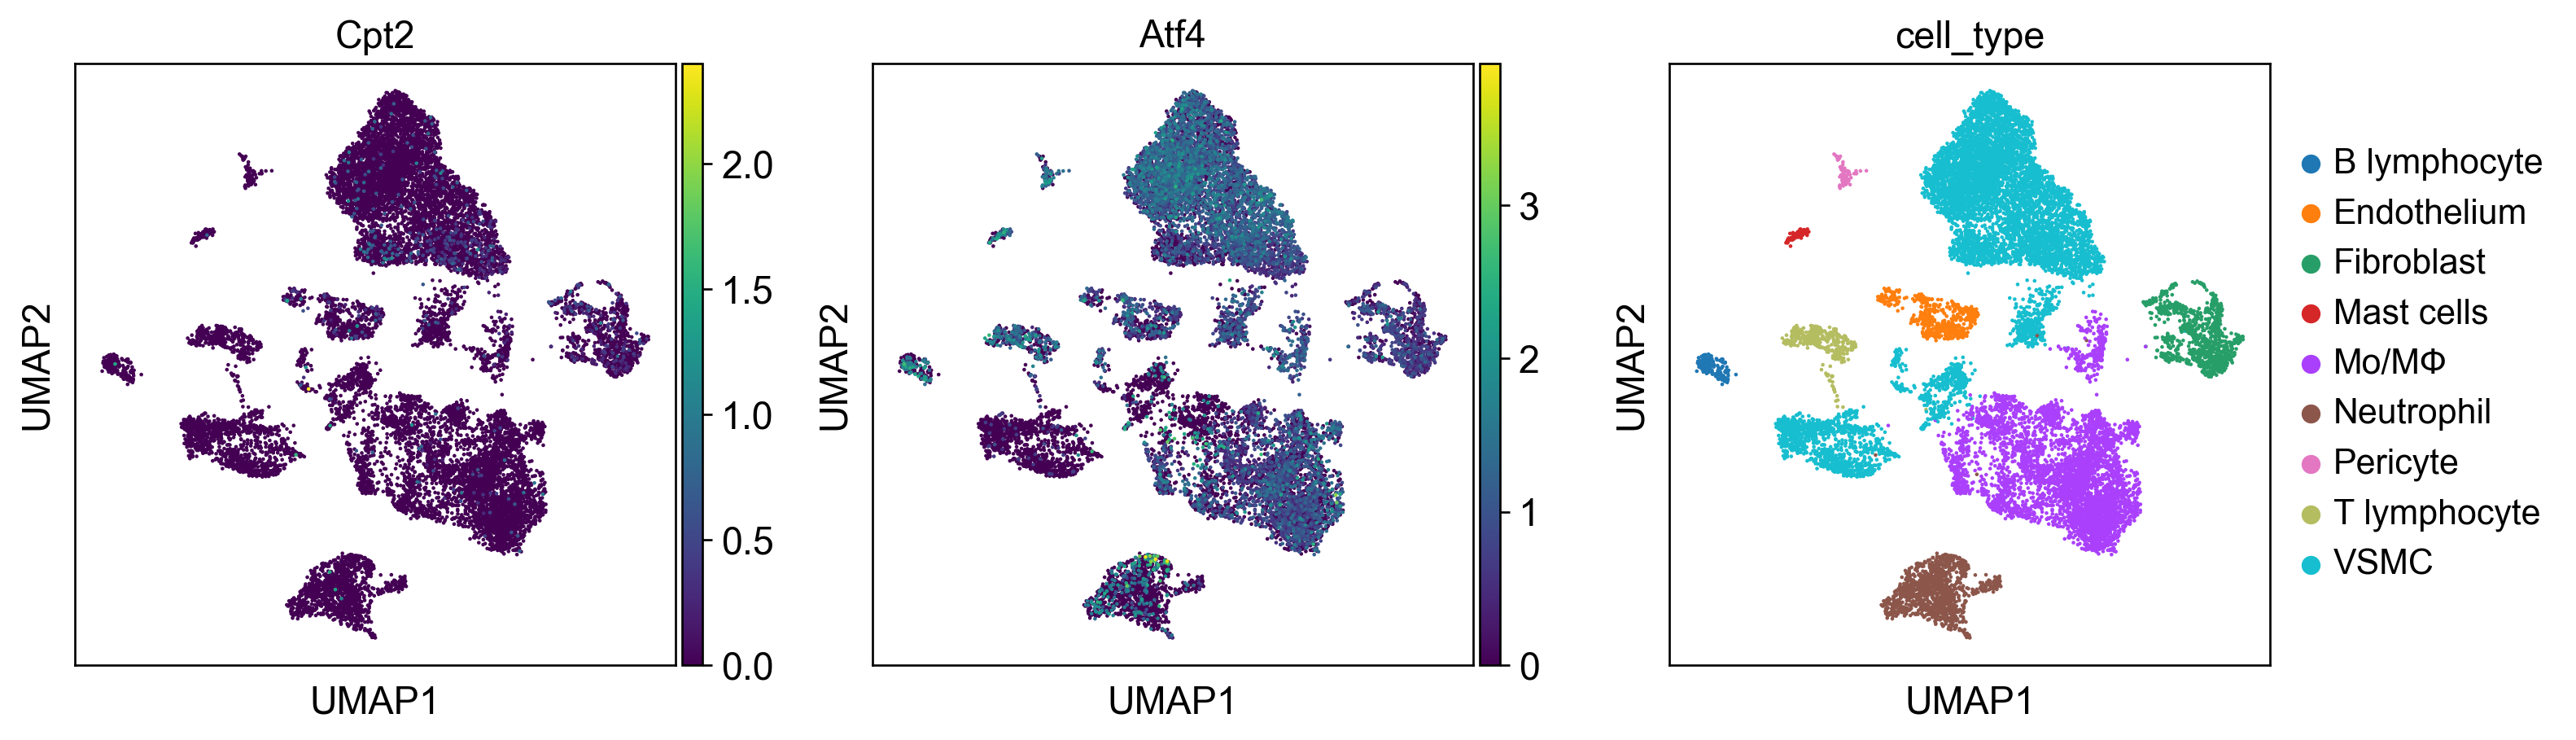

In [30]:
sc.pl.umap(
    adata,
    color=["Cpt2","Atf4","cell_type"],
)

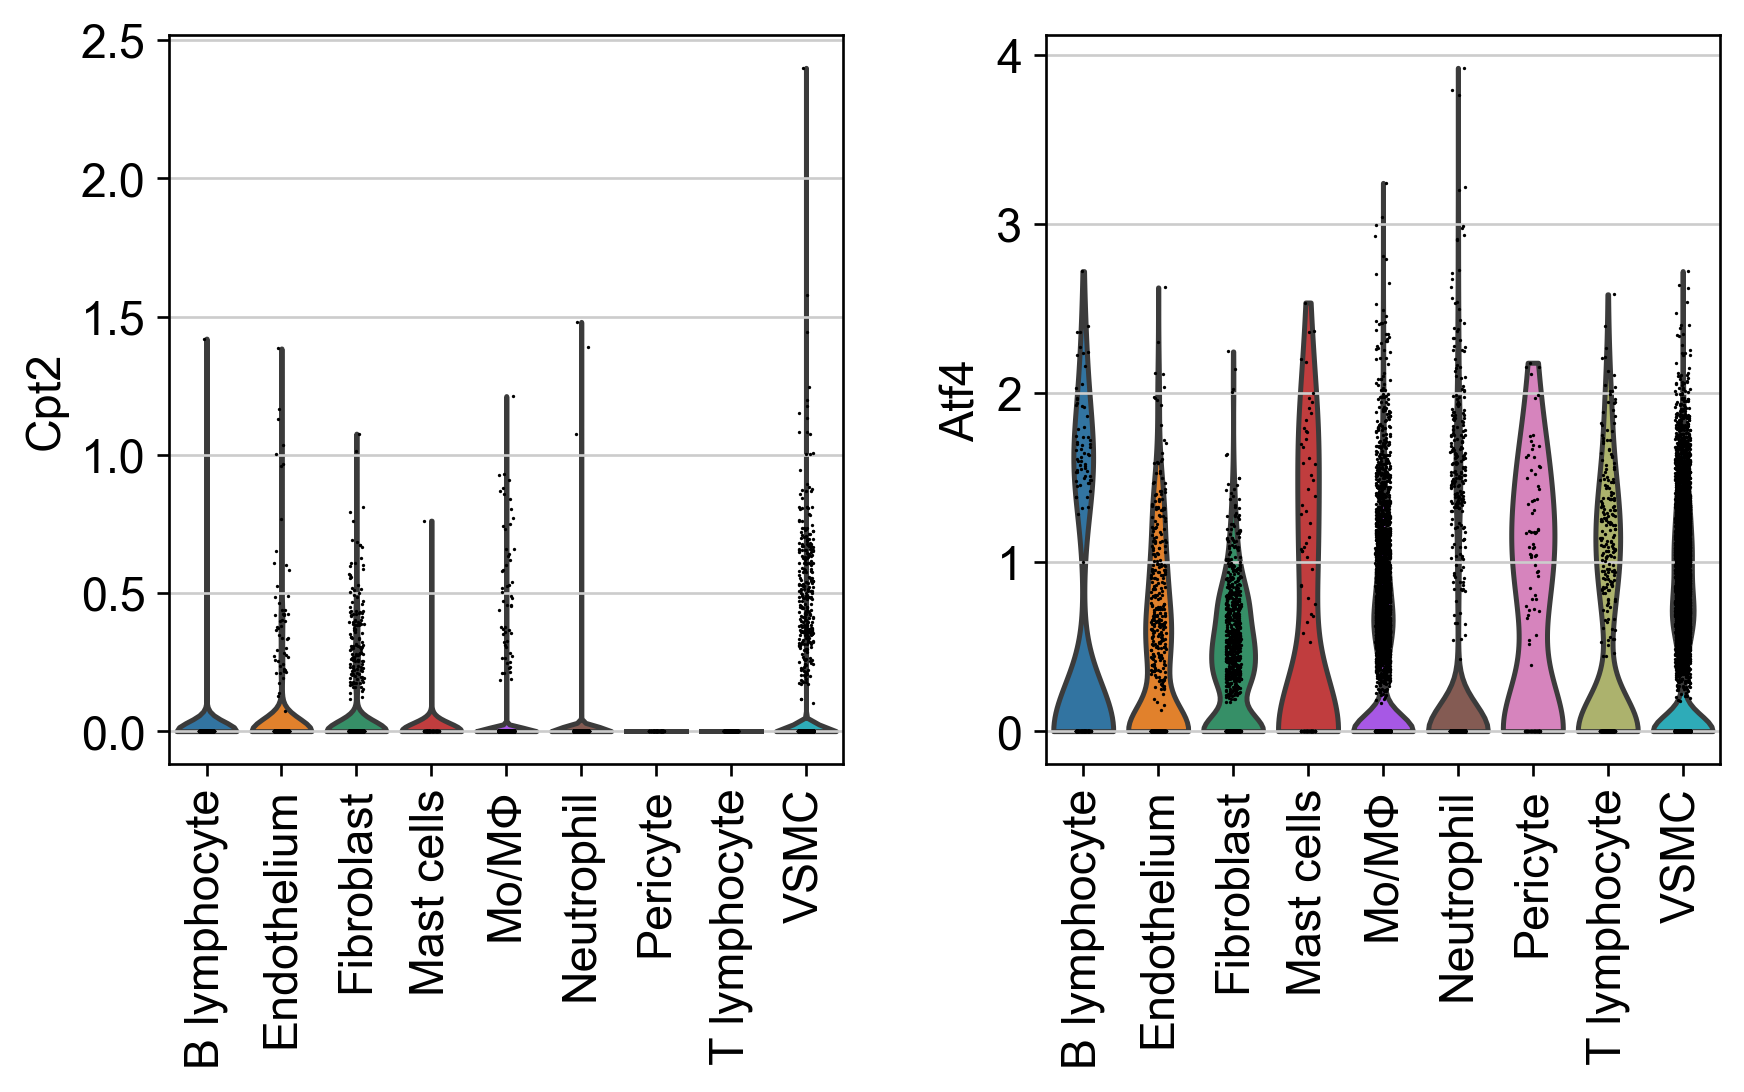

In [31]:
sc.pl.violin(adata, ["Cpt2","Atf4"], groupby="cell_type",rotation=90)

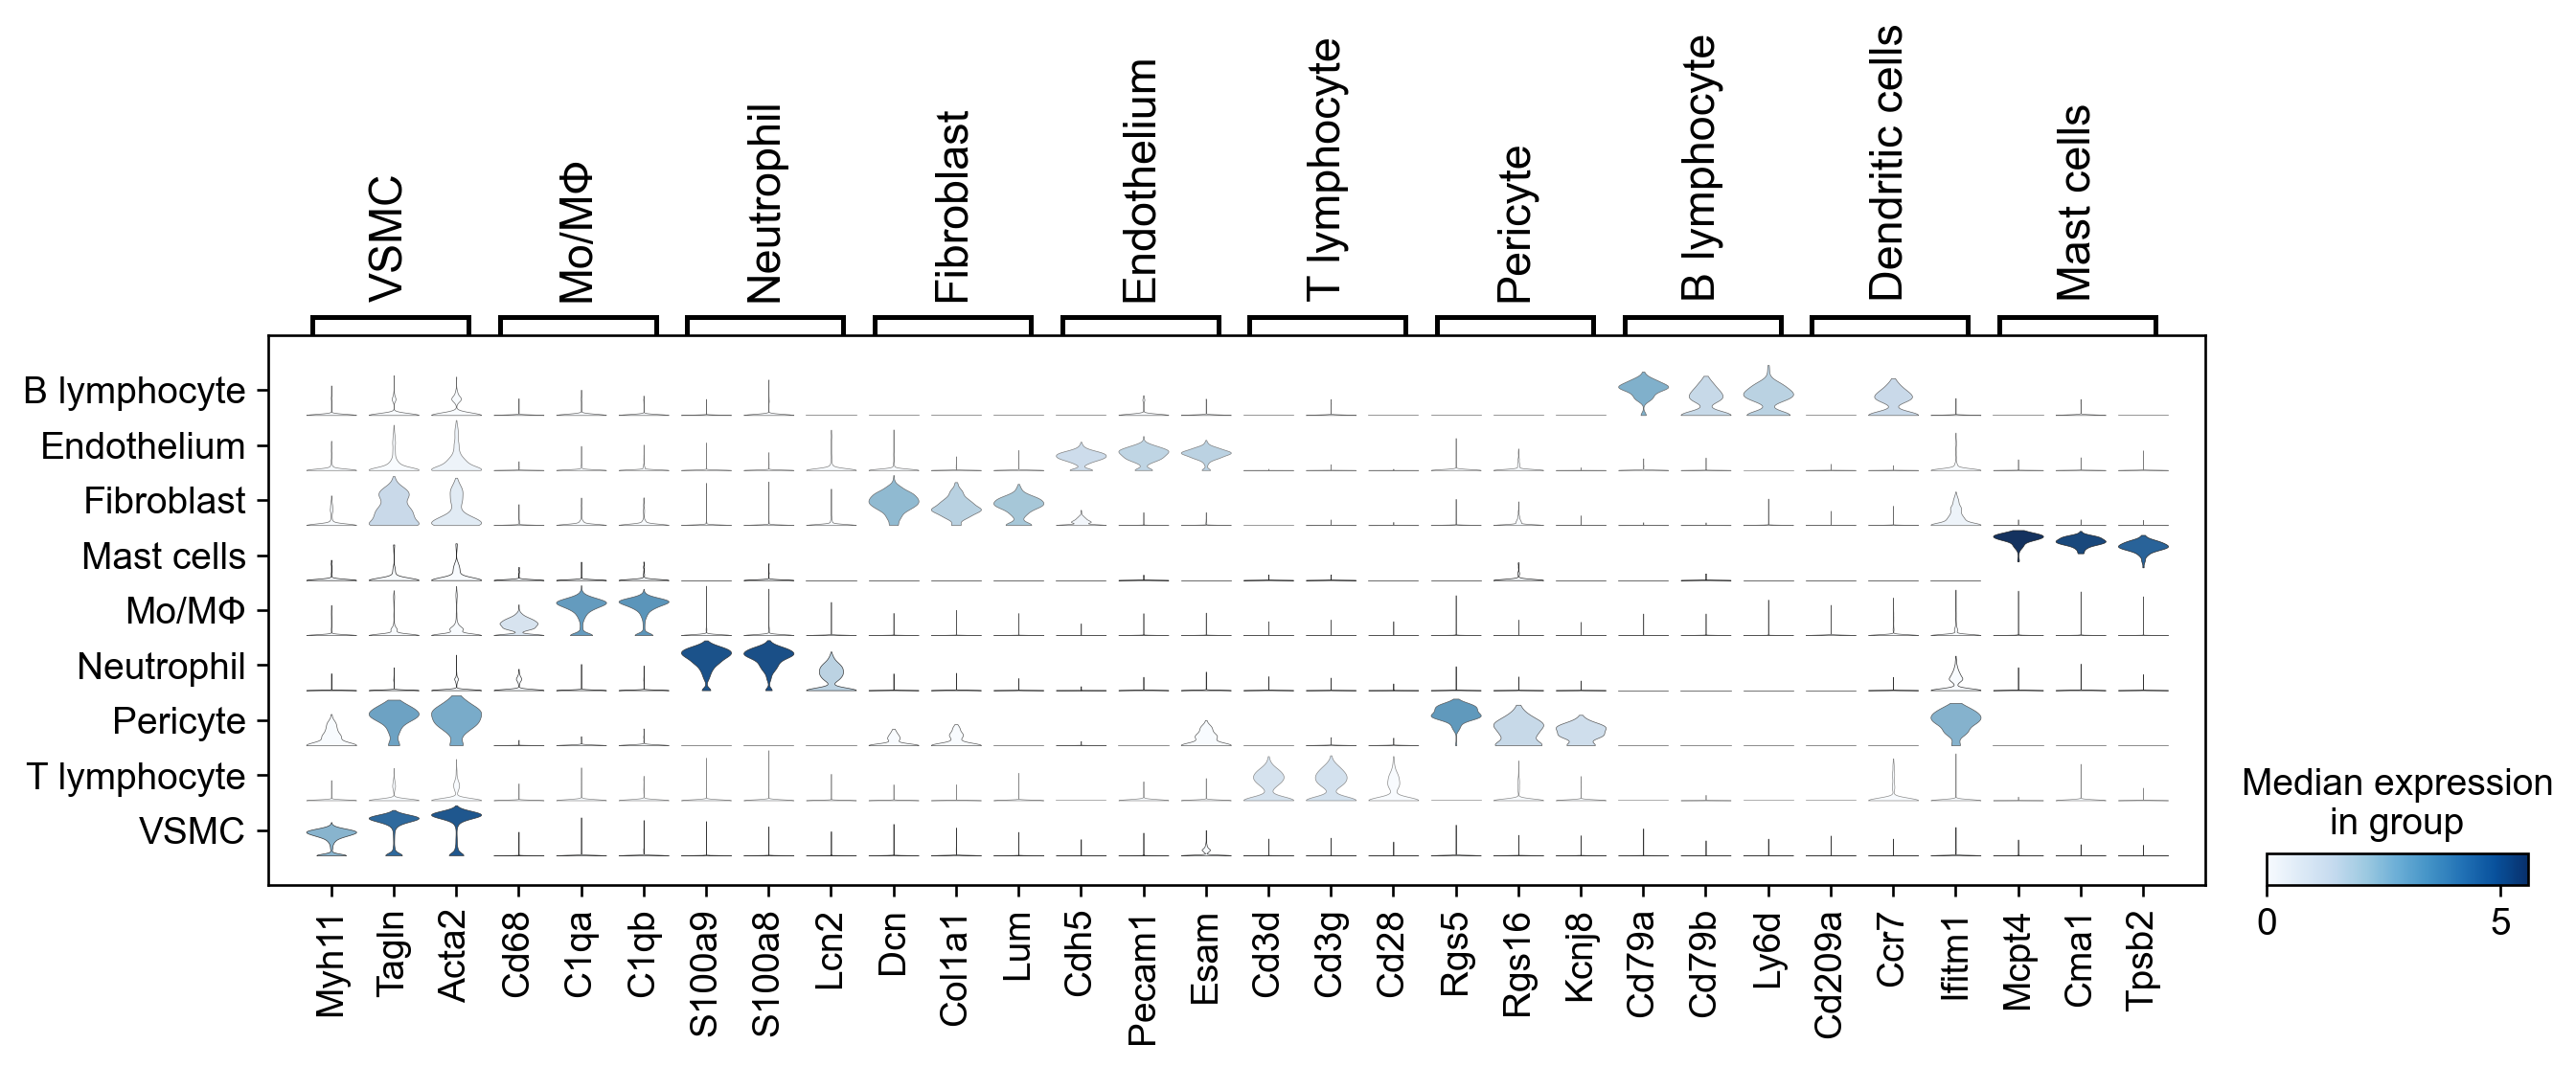

In [32]:
sc.pl.stacked_violin(adata, marker_genes, groupby="cell_type")

In [33]:
# save the data
adata.write("morrbid.h5ad")

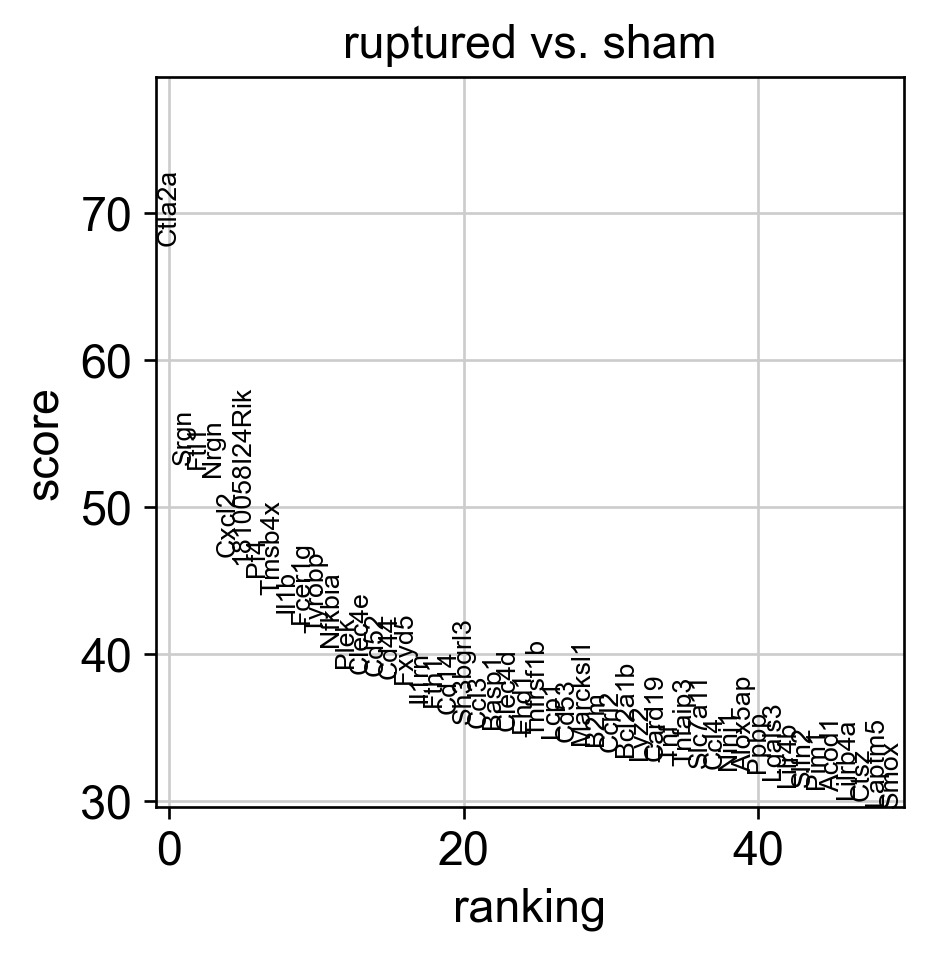

In [54]:
sc.tl.rank_genes_groups(adata, 'sample', groups=['ruptured'], reference='sham', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['ruptured'], n_genes=50)

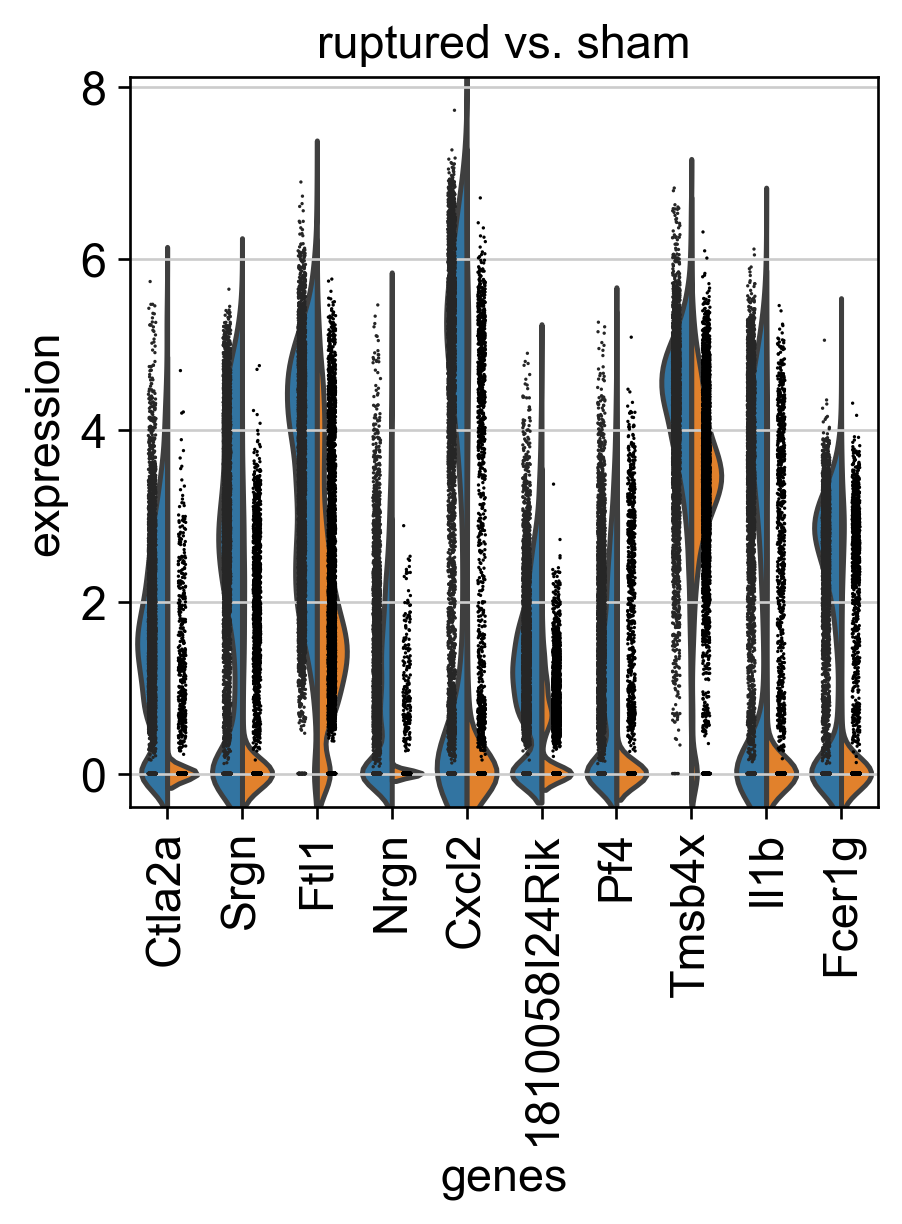

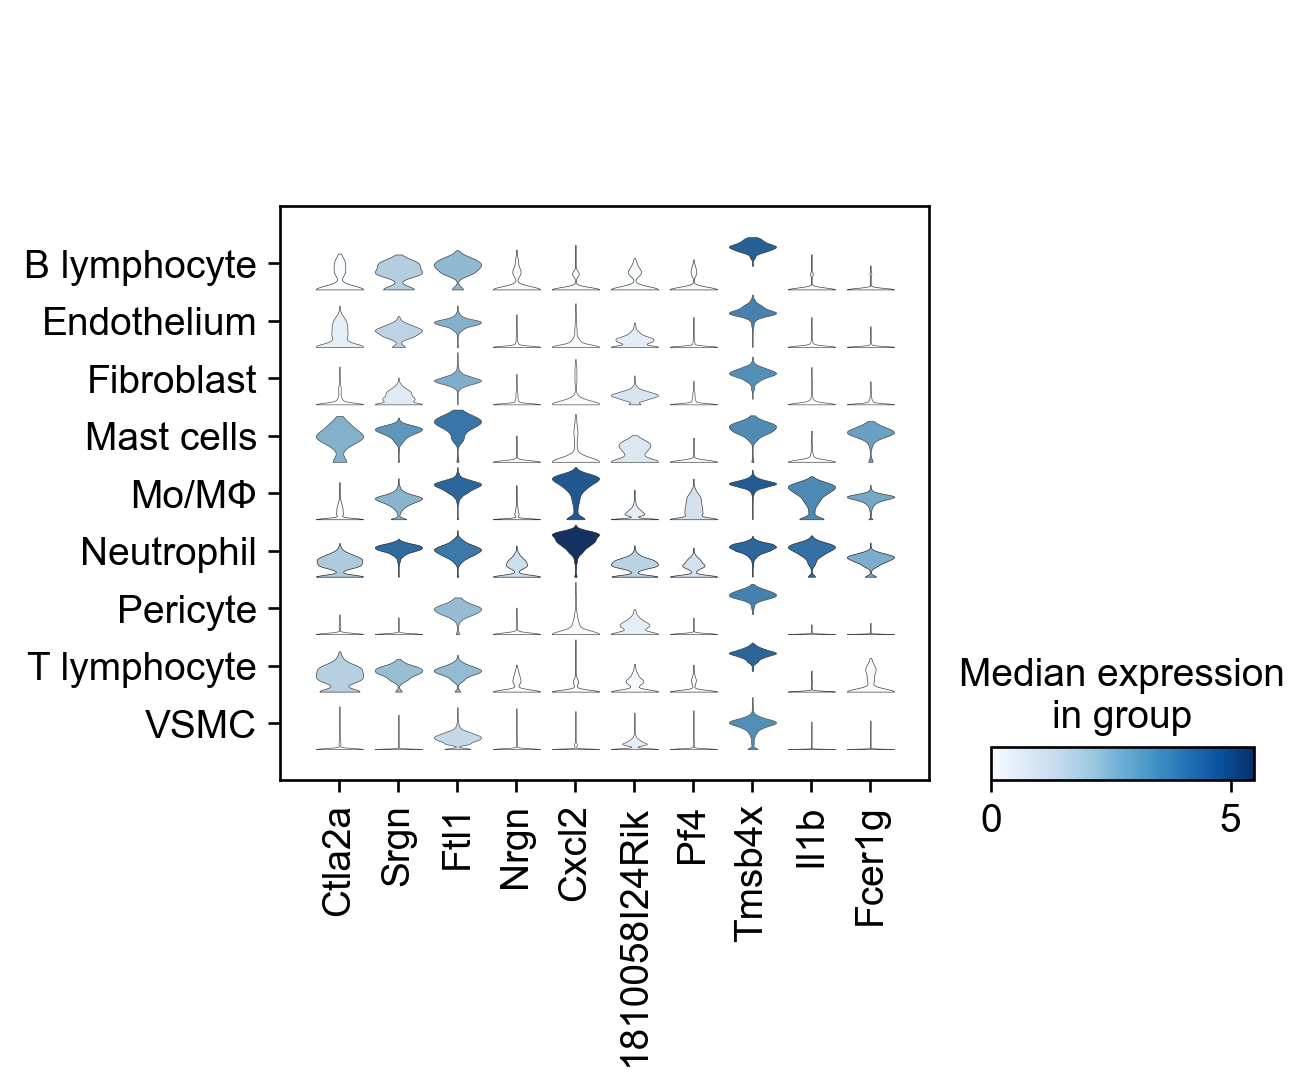

In [55]:
sc.pl.rank_genes_groups_violin(adata, groups='ruptured', n_genes=10)

# plot the same genes as violins across all the datasets.

# convert numpy.recarray to list
mynames = [x[0] for x in adata.uns['rank_genes_groups']['names'][:10]]
sc.pl.stacked_violin(adata, mynames, groupby = 'cell_type', rotation = 90)

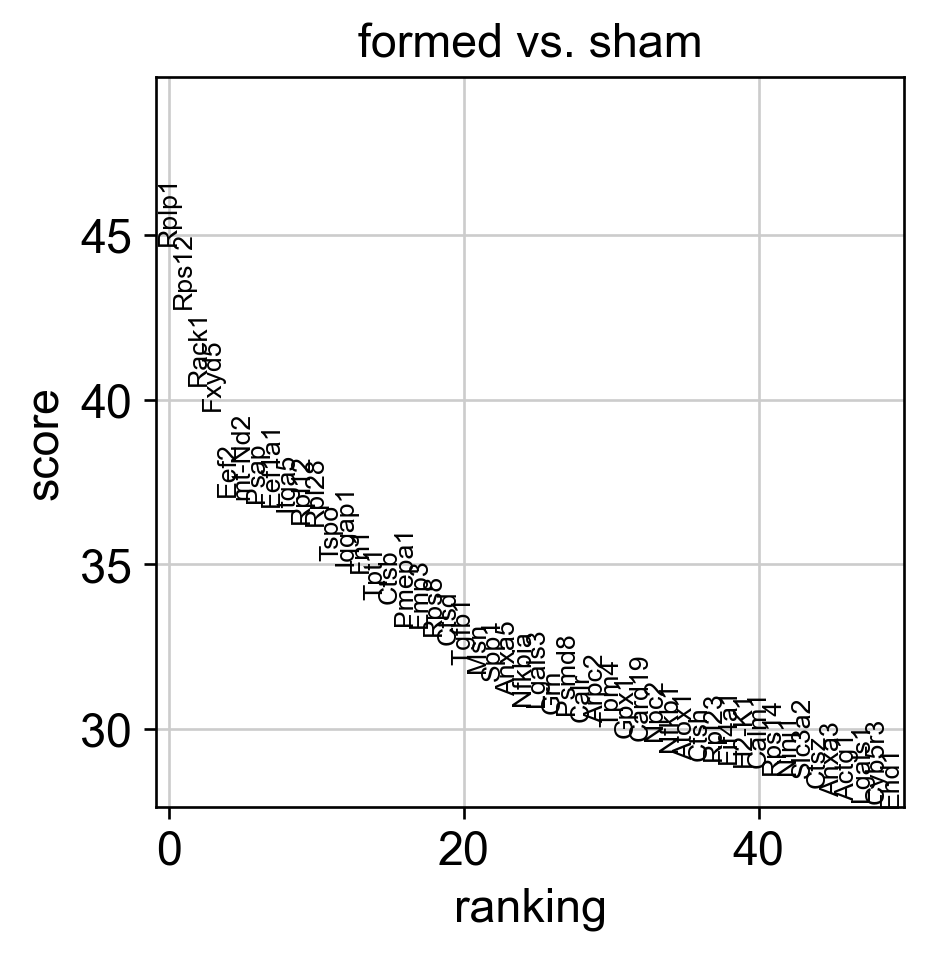

In [56]:
sc.tl.rank_genes_groups(adata, 'sample', groups=['formed'], reference='sham', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['formed'], n_genes=50)

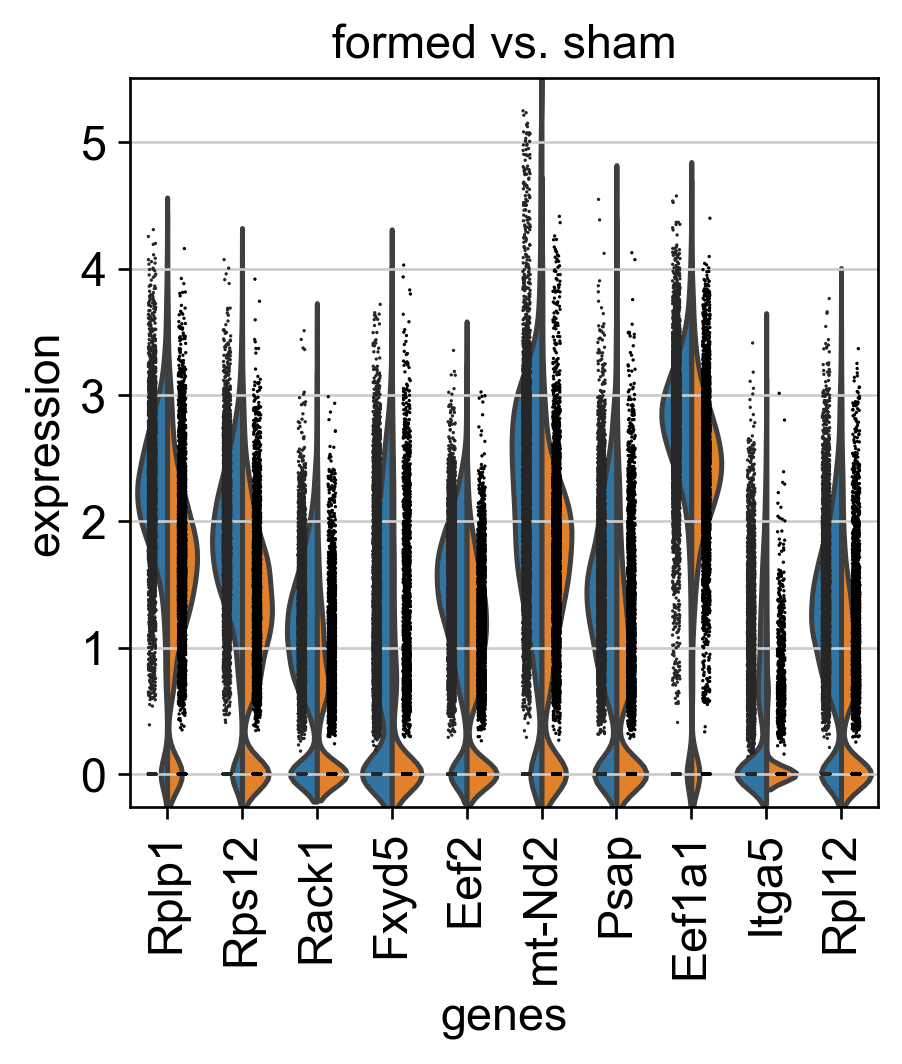

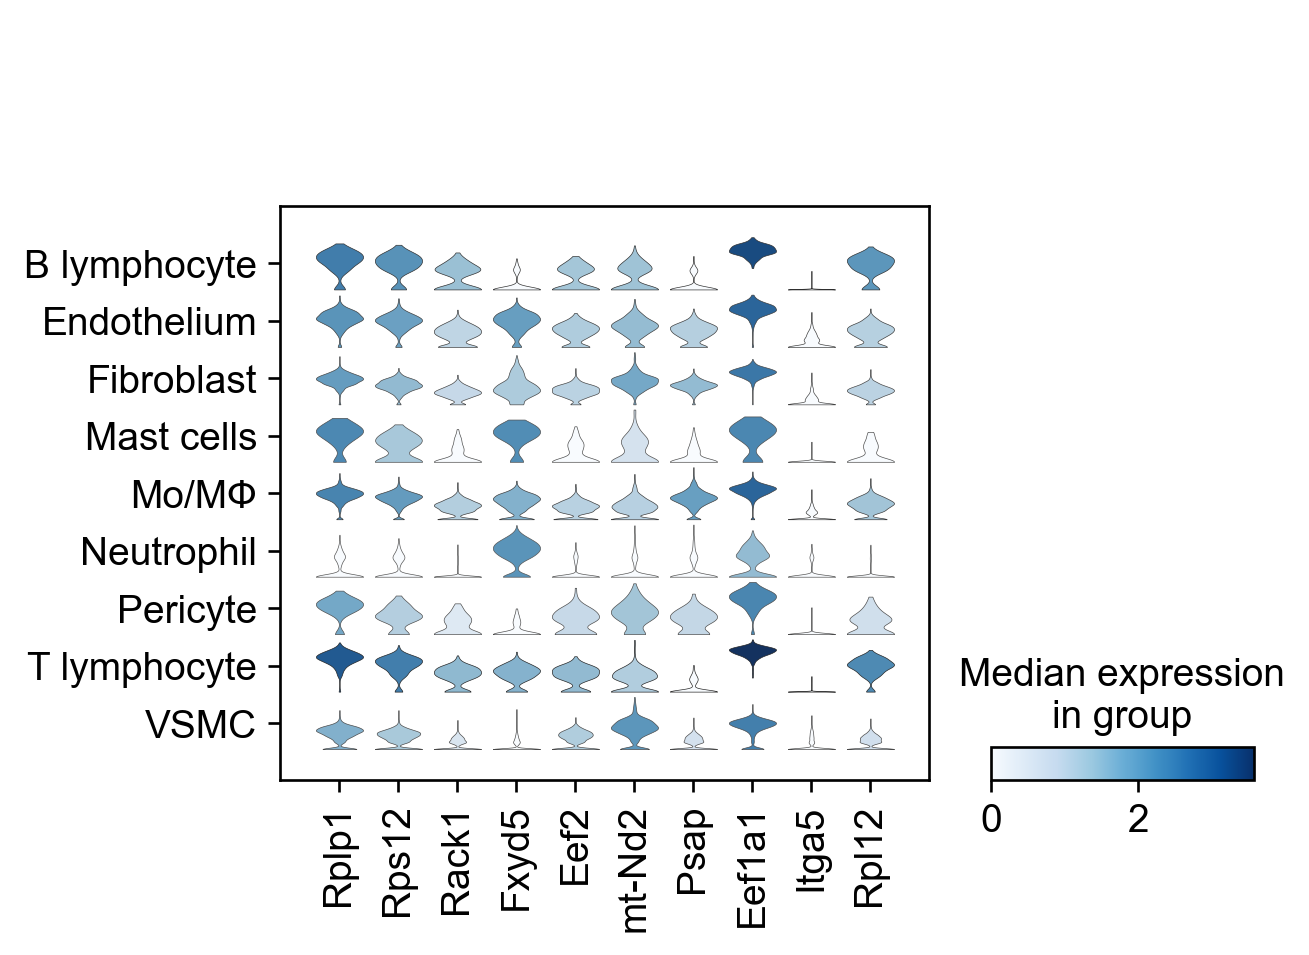

In [57]:
sc.pl.rank_genes_groups_violin(adata, groups='formed', n_genes=10)

# plot the same genes as violins across all the datasets.

# convert numpy.recarray to list
mynames = [x[0] for x in adata.uns['rank_genes_groups']['names'][:10]]
sc.pl.stacked_violin(adata, mynames, groupby = 'cell_type', rotation = 90)

In [67]:
gene_rank = sc.get.rank_genes_groups_df(adata, group='formed')[['names','logfoldchanges']]
gene_rank.sort_values(by=['logfoldchanges'], inplace=True, ascending=False)

# calculate_qc_metrics will calculate number of cells per gene
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

# filter for genes expressed in at least 30 cells.
gene_rank = gene_rank[gene_rank['names'].isin(adata.var_names[adata.var.n_cells_by_counts>30])]


gene_rank['names'] = gene_rank['names'].str.upper()
gene_rank

names  logfoldchanges
9928            MMP3       22.183315
10221          PLET1       21.980675
8798   6030407O03RIK       21.734493
9385            GJB4       21.191483
9428   3425401B19RIK       21.144796
...              ...             ...
17527         VPREB3       -7.696663
16143        GM48905      -18.594194
15795           KLK6      -19.149544
16831           GAD1      -20.705954
17266           PAX5      -22.465544

[14877 rows x 2 columns]

In [68]:
gene_list = gene_rank['names'] 
glist = gene_list.squeeze().str.strip().to_list()
print(glist[:10])

['MMP3', 'PLET1', '6030407O03RIK', 'GJB4', '3425401B19RIK', 'NPY', 'DOXL1', 'DHRS9', 'GM39321', '9830107B12RIK']


In [69]:
enr = gp.enrichr(gene_list=glist, # or "./tests/data/gene_list.txt",
                 gene_sets='MSigDB_Hallmark_2020',
                 organism='Mouse', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )

In [70]:
enr.results.head(5)

Gene_set                           Term  Overlap       P-value  \
0  MSigDB_Hallmark_2020                Mitotic Spindle  196/199  1.085669e-21   
1  MSigDB_Hallmark_2020  TNF-alpha Signaling via NF-kB  195/200  1.978822e-19   
2  MSigDB_Hallmark_2020                   Adipogenesis  193/200  2.237245e-17   
3  MSigDB_Hallmark_2020                 Myc Targets V1  192/200  1.912709e-16   
4  MSigDB_Hallmark_2020                 UV Response Dn  141/144  5.675417e-15   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0      5.428344e-20            0                     0   22.785006   
1      4.947055e-18            0                     0   13.595014   
2      3.728741e-16            0                     0    9.606063   
3      2.390887e-15            0                     0    8.359551   
4      5.675417e-14            0                     0   16.330076   

   Combined Score                                              Genes  
0     1099.879856  TRIO;ITSN1;SMC3;SMC4;UXT;PREX1;OPHN1;PPP4R2;CD...  
1      585.491247  SERPINE1;ICAM1;IFIT2;MYC;ZC3H12A;NAMPT;IL12B;C...  
2      368.283981  ITSN1;ARAF;GHITM;MYLK;LIPE;SCP2;MCCC1;ECH1;OMD...  
3      302.555882  EIF4A1;HDDC2;RPL34;HNRNPU;HNRNPR;PWP1;PHB2;RPL...  
4      535.669480  IRS1;SERPINE1;PRDM2;NR3C1;IGF1R;RGS4;GJA1;EFEM...

In [71]:
from gseapy import barplot, dotplot

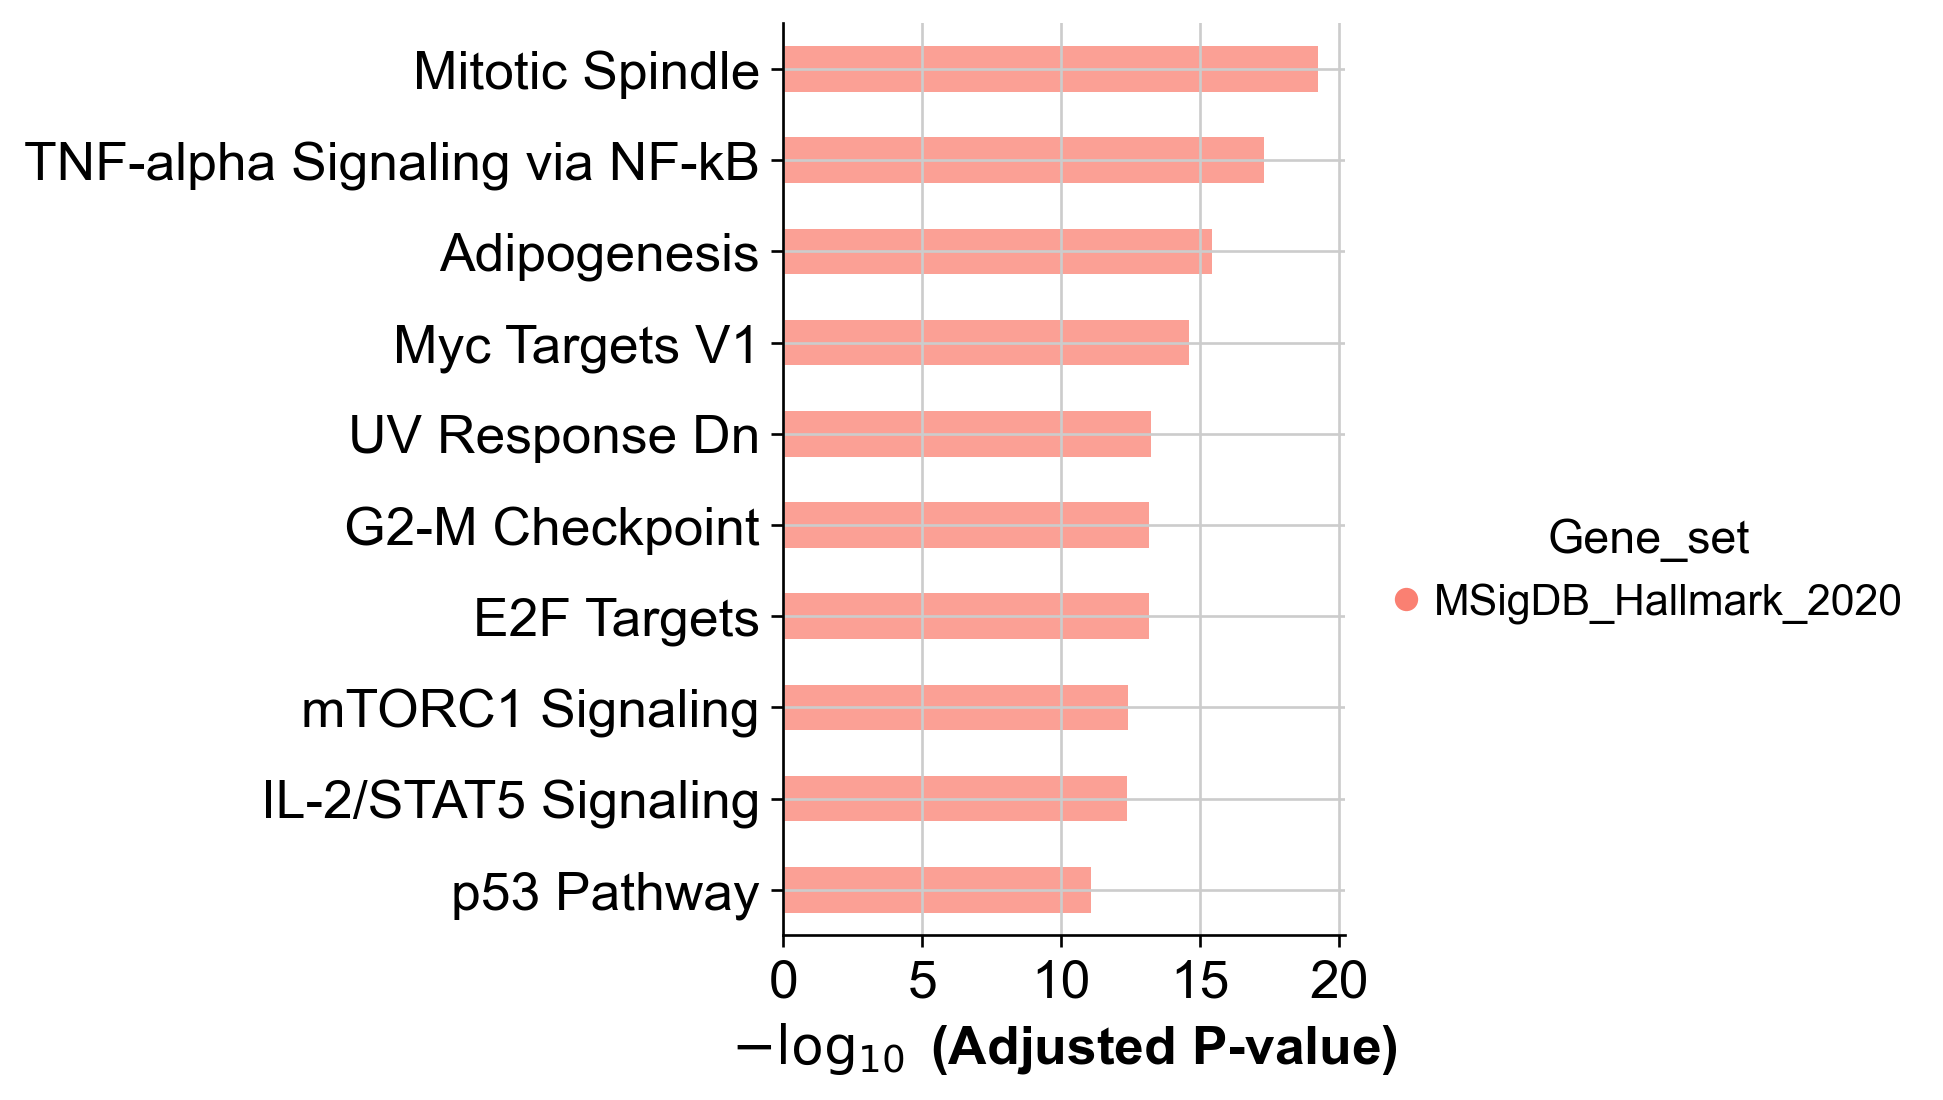

In [77]:
# categorical scatterplot
ax = barplot(enr.results,
              column="Adjusted P-value",
              group='Gene_set', # set group, so you could do a multi-sample/library comparsion
              size=10,
              top_term=10,
              figsize=(3,5),
             )

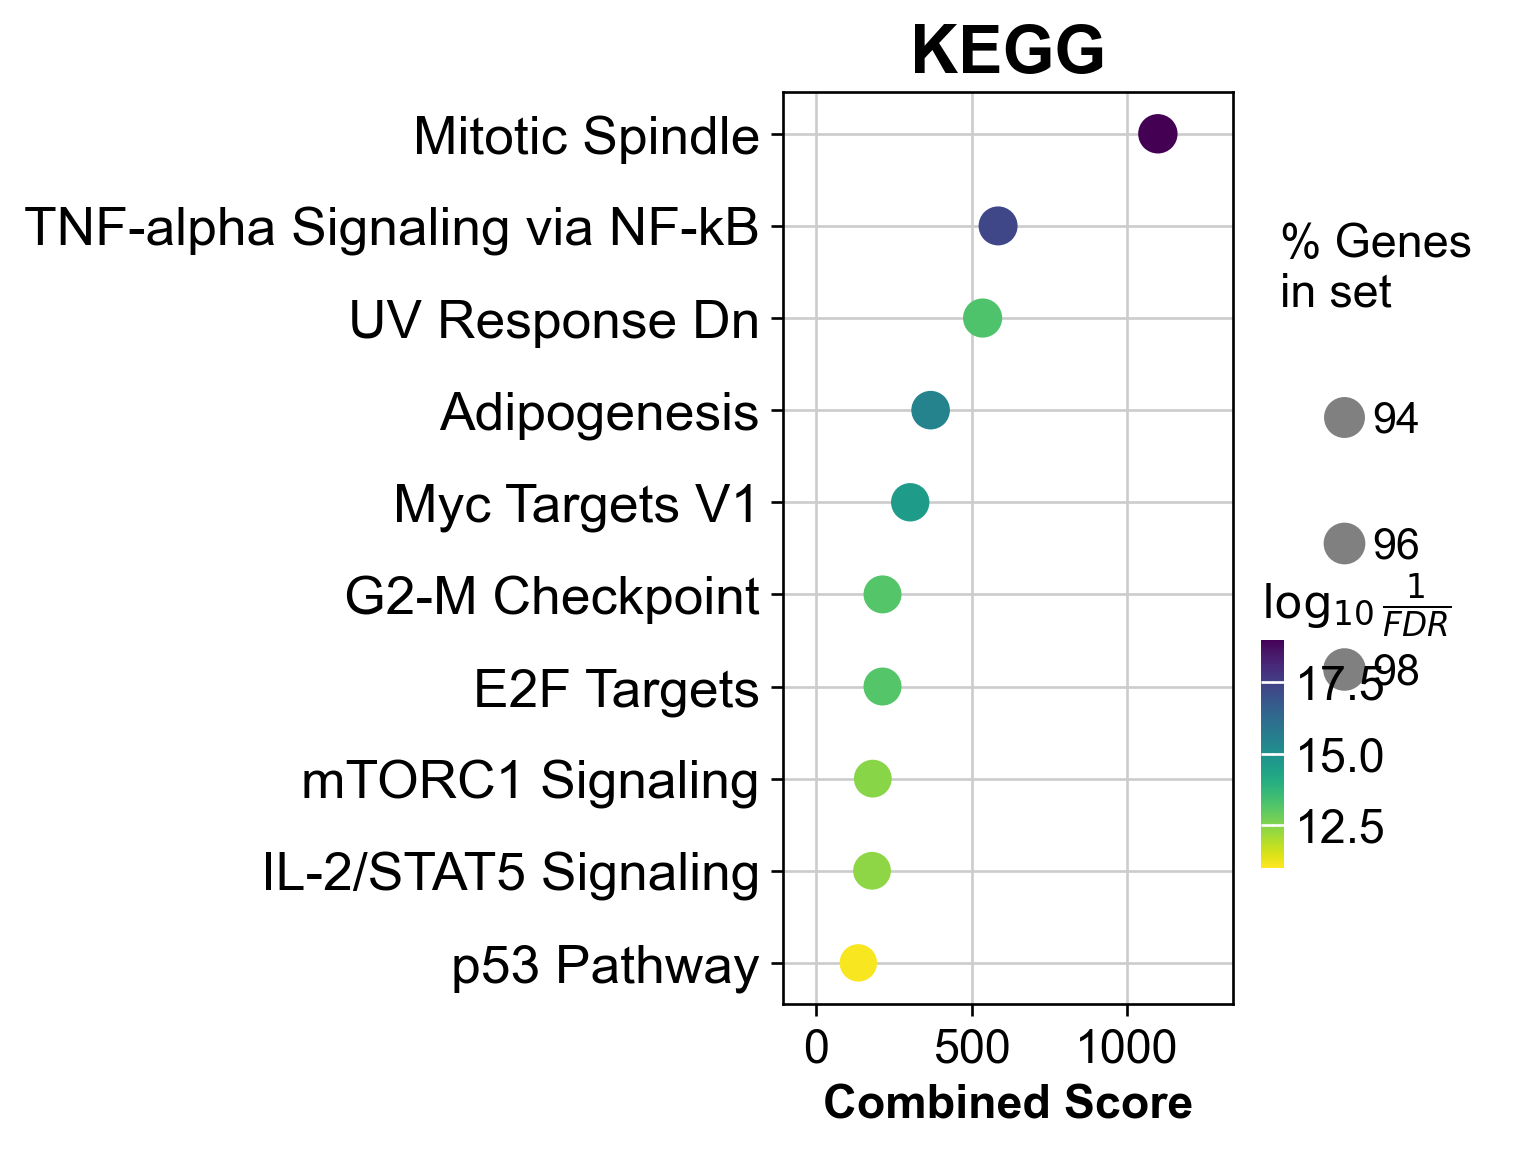

In [84]:
ax = dotplot(enr.res2d, title='KEGG',cmap='viridis_r', size=2, figsize=(3,5))